Author: Justus Heilingbrunner
***

In [349]:
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import math
import random
import os
import requests
import dotenv
import re
import time
import torch

import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import mads_dl

In [350]:
pd.options.display.max_columns = None

torch.set_default_dtype(torch.float)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# torch.set_num_threads(1)

RANDOM_SEED = 123
os.environ["PL_GLOBAL_SEED"] = str(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

***
***
# The Data



## Hub List all time + pick up and drop offs.csv

In [37]:
df = pd.read_csv('Data/Hub List all time + pick up and drop offs.csv')
df.head()

,id,name,state,created_at,maximum_capacity,pickups,dropoffs
0,30467,Stadtwerke Pop-Up,public,2024-09-12 12:45:29.843902,0,4,1
1,30466,Mobilitätsfest Pop-up,public,2024-09-12 12:07:04.481416,0,15,16
2,30464,Pop Up Rathaus event,public,2024-09-12 07:25:05.597799,20,7,3
3,30434,Felde Gemeindezentrum,public,2024-09-08 09:01:16.289455,18,7,9
4,30420,IPN Pop Up,disabled,2024-09-05 20:53:56.364054,10,0,0


In [38]:
df.head(233)

,id,name,state,created_at,maximum_capacity,pickups,dropoffs
0,30467,Stadtwerke Pop-Up,public,2024-09-12 12:45:29.843902,0,4,1
1,30466,Mobilitätsfest Pop-up,public,2024-09-12 12:07:04.481416,0,15,16
2,30464,Pop Up Rathaus event,public,2024-09-12 07:25:05.597799,20,7,3
3,30434,Felde Gemeindezentrum,public,2024-09-08 09:01:16.289455,18,7,9
4,30420,IPN Pop Up,disabled,2024-09-05 20:53:56.364054,10,0,0
...,...,...,...,...,...,...,...
228,24371,Anleger Reventlou,public,2022-12-19 13:18:10.719836,50,30232,30138
229,24370,Alter Markt,public,2022-12-19 13:18:10.313777,25,15439,15676
230,24369,Alte Mu/Brunswiker Str.,public,2022-12-19 13:18:09.902522,15,7544,7593
231,24368,Umsteiger,public,2022-12-19 13:18:09.467309,20,7633,7629


In [40]:
df['name'].nunique(), df['id'].nunique()

(233, 233)

In [42]:
df['name'].unique()

array(['Stadtwerke Pop-Up', 'Mobilitätsfest Pop-up',
       'Pop Up Rathaus event', 'Felde Gemeindezentrum', 'IPN Pop Up ',
       'SH Netz Cup Pop Up', 'Wankendorf Zob', 'Sporthalle Saxtorfer Weg',
       'Osterby Veranstaltung Pop Up ', 'Hohes Arsenal', 'Jungmannufer',
       'Eiche Dänischenhagen', 'Bushaltestelle Eiderbrücke',
       'Herzog-Friedrich-Straße (ZOB)', 'Rondeel', 'VHS Kurs ',
       'TÖZ Eckernförde ', 'Martinshaus', 'Pop-up Barsbek Korntage',
       'Pop Up VeloCenter ', 'REWE Klausdorf', 'Ostseepark',
       'Stadtwerke / Bürgerhaus Klausdorf', 'Bahnhof Raisdorf',
       'Freibad Raisdorf (saisonal bis 22.09.24)',
       'Rathaus Schwentinental', 'Pop-up Seewiese Bünsdorf',
       'Eiderbad Saison-Station', 'Kiwo Sparkassen Service',
       'B502 Schönkirchener Straße ', 'Langer Rehm P+R',
       'Langer Rehm (Rewe)', 'Wörthstraße', 'KiWo Willestraße ',
       'ab 12 Uhr - KiWo Nordeingang', 'ab 12 Uhr - KiWo Südeingang',
       'KiWo Nordmarksportfeld', 'KiWo Prinz

In [43]:
df['id'].unique()

array([30467, 30466, 30464, 30434, 30420, 30390, 30282, 30207, 30185,
       30156, 30155, 30151, 30147, 30146, 30145, 30126, 30121, 30120,
       30095, 30084, 30027, 30026, 30025, 30024, 30023, 30022, 30011,
       29982, 29974, 29965, 29964, 29963, 29946, 29942, 29941, 29940,
       29939, 29938, 29937, 29936, 29935, 29934, 29933, 29745, 29663,
       29347, 29346, 29345, 29253, 29224, 29200, 29198, 29147, 29112,
       29109, 29083, 29049, 28932, 28814, 28813, 28812, 28811, 28804,
       28803, 28802, 28801, 28800, 28799, 28798, 28797, 28796, 28795,
       28794, 28793, 28792, 28791, 28790, 28789, 28749, 28738, 28264,
       27717, 27567, 27452, 27451, 27450, 27449, 27448, 27447, 27446,
       27445, 27444, 27443, 27442, 27441, 27440, 27382, 27381, 27380,
       27379, 27378, 27377, 27376, 27375, 27374, 27373, 27372, 27209,
       27183, 26889, 26805, 26730, 26725, 26724, 26708, 26653, 26224,
       26209, 24602, 24482, 24481, 24479, 24478, 24477, 24476, 24475,
       24474, 24473,

**Hub List all time + pick up and drop offs.csv | Features:**

1. **id**: 
2. **name**: 
3. **state**: 
4. **created_at**: 
5. **maximum_capacity**: 
6. **pickups**: 
7. **dropoffs**: 

In [7]:
print('number of missing values:', df.isnull().sum().sum())
print('number of NaN values:', df.isna().sum().sum())
df.info()

number of missing values: 0
number of NaN values: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                233 non-null    int64 
 1   name              233 non-null    object
 2   state             233 non-null    object
 3   created_at        233 non-null    object
 4   maximum_capacity  233 non-null    int64 
 5   pickups           233 non-null    int64 
 6   dropoffs          233 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 12.9+ KB


In [21]:
# look at dataset
print('Shape:', df.shape)
print('Columns:', df.columns)
print('\ndifferent names:', df['name'].nunique())
print('unique states:', df['state'].nunique())
print(df['state'].unique())
print('\nmaximal capacity:', df['maximum_capacity'].max())
print('minimal capacity:', df['maximum_capacity'].min())
print(df['maximum_capacity'].unique())
print('\n')
print(df['maximum_capacity'].value_counts()[:5])

Shape: (233, 7)
Columns: Index(['id', 'name', 'state', 'created_at', 'maximum_capacity', 'pickups',
       'dropoffs'],
      dtype='object')

different names: 233
unique states: 3
['public' 'disabled' 'fellows']

maximal capacity: 150
minimal capacity: 0
[  0  20  18  10   7  15  16  12  50   6  30  25 150  19  14  40  21  80
  35]


maximum_capacity
15    78
20    58
30    28
0     23
25    20
Name: count, dtype: int64


## 2024 - Hub ID & Drop Off - Pick Up numbers.csv

In [4]:
df_time = pd.read_csv('Data/2024 - Hub ID & Drop Off - Pick Up numbers.csv', sep=';')
df_time.head()

,hub_id,Days in full_date,Average bike_count,# of unique dropoff_hub_id,# of unique pickup_hub_id
0,2180.0,01/01/2024,6.282412,NaN,NaN
1,2180.0,02/01/2024,6.080100,NaN,NaN
2,2180.0,04/01/2024,6.078173,NaN,NaN
3,2180.0,05/01/2024,5.936238,NaN,NaN
4,2180.0,07/01/2024,6.443539,NaN,NaN


**2024 - Hub ID & Drop Off - Pick Up numbers.csv | Features:**

1. **hub_id**: 
2. **days in full_date**: 
3. **Average bike_count**: 
4. **# of unique dropoff_hub_id**: 
5. **# of unique pcikup_hub_id**: 

In [8]:
print('number of missing values:', df_time.isnull().sum().sum())
print('number of NaN values:', df_time.isna().sum().sum())
df_time.info()

number of missing values: 446
number of NaN values: 446
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6930 entries, 0 to 6929
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   hub_id                      6930 non-null   float64
 1   Days in full_date           6930 non-null   object 
 2   Average bike_count          6930 non-null   float64
 3   # of unique dropoff_hub_id  6707 non-null   float64
 4   # of unique pickup_hub_id   6707 non-null   float64
dtypes: float64(4), object(1)
memory usage: 270.8+ KB


In [6]:
# look at dataset
print('Shape:', df_time.shape)
print('Columns:', df_time.columns)

Shape: (6930, 5)
Columns: Index(['hub_id', 'Days in full_date', 'Average bike_count',
       '# of unique dropoff_hub_id', '# of unique pickup_hub_id'],
      dtype='object')


***

## Grafiken

In [59]:
df_time.head()

,hub_id,Days in full_date,Average bike_count,# of unique dropoff_hub_id,# of unique pickup_hub_id
0,2180.0,01/01/2024,6.282412,NaN,NaN
1,2180.0,02/01/2024,6.080100,NaN,NaN
2,2180.0,04/01/2024,6.078173,NaN,NaN
3,2180.0,05/01/2024,5.936238,NaN,NaN
4,2180.0,07/01/2024,6.443539,NaN,NaN


In [60]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6930 entries, 0 to 6929
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   hub_id                      6930 non-null   float64
 1   Days in full_date           6930 non-null   object 
 2   Average bike_count          6930 non-null   float64
 3   # of unique dropoff_hub_id  6707 non-null   float64
 4   # of unique pickup_hub_id   6707 non-null   float64
dtypes: float64(4), object(1)
memory usage: 270.8+ KB


In [61]:
df_time['Days in full_date'] = pd.to_datetime(df_time['Days in full_date'], format='%d/%m/%Y')
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6930 entries, 0 to 6929
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   hub_id                      6930 non-null   float64       
 1   Days in full_date           6930 non-null   datetime64[ns]
 2   Average bike_count          6930 non-null   float64       
 3   # of unique dropoff_hub_id  6707 non-null   float64       
 4   # of unique pickup_hub_id   6707 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 270.8 KB


In [85]:
# hub_id = 24383 # cau sportstätten
# 24379 # RBZ
# df_filtered = df_time[df_time['hub_id'] == hub_id]

hub_ids = [24383, 24385]
df_filtered = df_time[df_time['hub_id'].isin(hub_ids)]

c:\Users\JustusHeilingbrunner\Documents\UNI\WS_2024_25\Application_Project\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\JustusHeilingbrunner\Documents\UNI\WS_2024_25\Application_Project\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


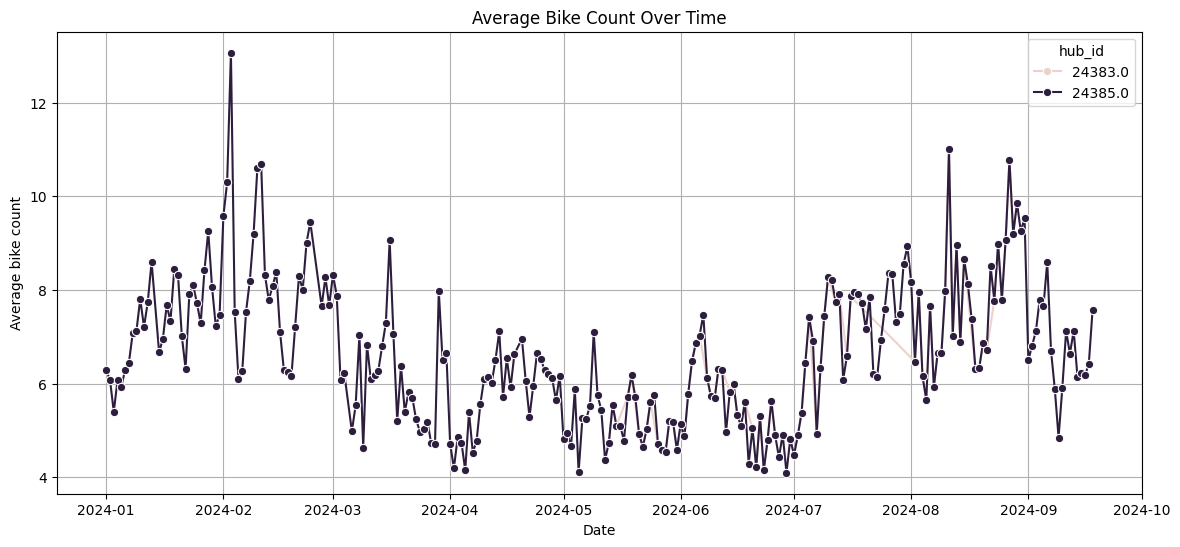

c:\Users\JustusHeilingbrunner\Documents\UNI\WS_2024_25\Application_Project\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\JustusHeilingbrunner\Documents\UNI\WS_2024_25\Application_Project\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


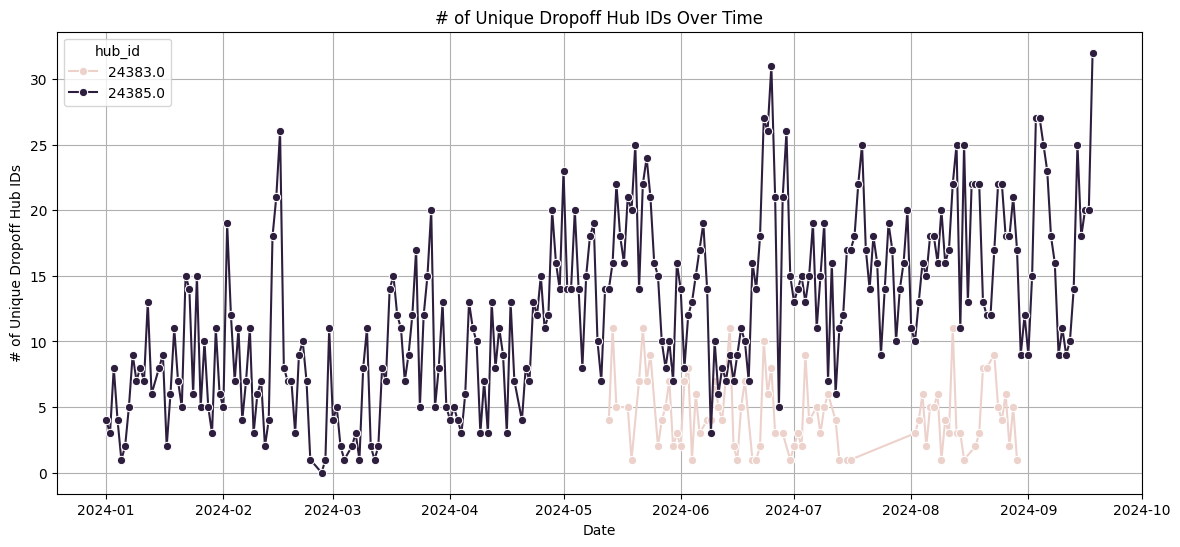

c:\Users\JustusHeilingbrunner\Documents\UNI\WS_2024_25\Application_Project\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\JustusHeilingbrunner\Documents\UNI\WS_2024_25\Application_Project\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


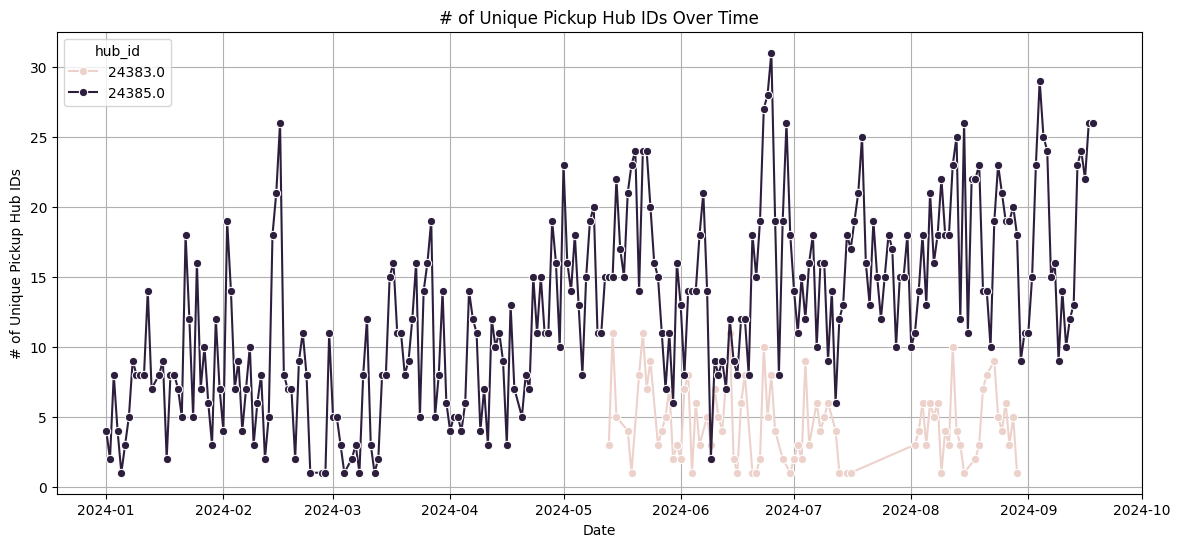

In [86]:
# Definieren Sie die Größe der Figure# Plot für Average bike_count
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_filtered, x='Days in full_date', y='Average bike_count', hue='hub_id', marker='o')
plt.title('Average Bike Count Over Time')
plt.xlabel('Date')
plt.ylabel('Average bike count')
plt.grid(True)
plt.show()

# Plot für # of unique dropoff_hub_id
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_filtered, x='Days in full_date', y='# of unique dropoff_hub_id', hue='hub_id', marker='o', color="red")
plt.title('# of Unique Dropoff Hub IDs Over Time')
plt.xlabel('Date')
plt.ylabel('# of Unique Dropoff Hub IDs')
plt.grid(True)
plt.show()

# Plot für # of unique pickup_hub_id
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_filtered, x='Days in full_date', y='# of unique pickup_hub_id', hue='hub_id', marker='o', color="blue")
plt.title('# of Unique Pickup Hub IDs Over Time')
plt.xlabel('Date')
plt.ylabel('# of Unique Pickup Hub IDs')
plt.grid(True)
plt.show()

***
***

***
***
# Requests

## .env

In [117]:
# .env
config = dotenv.dotenv_values(".env")

PASSWORD = config["PASSWORD"]

CLIENT_SECRET = config["CLIENT_SECRET"]

In [120]:
token_url = 'https://accounts.kielregion.addix.io/realms/infoportal/protocol/openid-connect/token'
headers = {
    'Content-Type': 'application/x-www-form-urlencoded'
}

data = {
    'grant_type': 'password',
    'username': 'justus.heilingbrunner@student.fh-kiel.de', 
    'password': PASSWORD,
    'client_id': 'quantumleap',
    'client_secret': CLIENT_SECRET
}

response = requests.post(token_url, headers=headers, data=data)

if response.status_code == 200:
    token_data = response.json()
    access_token = token_data['access_token']
    print(f"Bearer Token successful requested")
    if access_token:
        dotenv_path = '.env'
        
        dotenv.set_key(dotenv_path, 'ACCESS_TOKEN', access_token)
        print(f"Access Token erfolgreich in die .env-Datei geschrieben.")
else:
    print(f"Error: {response.status_code}, {response.text}")

Bearer Token successful requested
Access Token erfolgreich in die .env-Datei geschrieben.


In [121]:
config = dotenv.dotenv_values(".env")

ACCESS_TOKEN = config["ACCESS_TOKEN"]

***
## actual Request

In [127]:
# request without attrs to get all avalable attrs

url = "https://apis.kielregion.addix.io/ql/v2/entities/urn:ngsi-ld:BikeHireDockingStation:KielRegion:30151"

params = {
    'type': 'BikeHireDockingStation',
    'fromDate': '2024-09-13T00:00:00',
    'toDate': '2024-09-13T00:02:05',
    # 'attrs': 'name,location',
    # 'aggrPeriod': 'hour',
    # 'aggrMethod': 'avg'
}

headers = {
    'NGSILD-Tenant': 'infoportal',
    'Authorization': f'Bearer {ACCESS_TOKEN}'
}

response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    response_data = response.json()
    print('got a response')
else:
    print(f"Error: {response.status_code}, {response.text}")

got a response


***
wetterdaten

In [128]:
# request without attrs to get all avalable attrs

# url = "https://apis.stag.kielregion.addix.io/ql/v2/entities/urn:ngsi-ld:WeatherObserved:OWM:5430967"
url = "https://apis.stag.kielregion.addix.io/ql/v2/entities/urn:ngsi-ld:WeatherObserved:OWM:5430967?type=WeatherObserved&fromDate=2024-10-17T00%3A00%3A00.000Z&toDate=2024-10-18T00%3A00%3A00.000Z"
# url = "https://apis.stag.kielregion.addix.io/ql/v2/entities/urn:ngsi-ld:WeatherObserved:OWM:5430967?type=WeatherObserved&fromDate=2024-10-17T00:00:00.000Z&toDate=2024-10-18T00:00:00.000Z"

params = {
    # 'type': 'WeatherObserved',
    # 'fromDate': '2024-10-17T00:00:00',
    # 'toDate': '2024-10-18T00:00:00',
}

headers = {
    'NGSILD-Tenant': 'infoportal',
    'Authorization': f'Bearer {ACCESS_TOKEN}'
}

response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    response_data = response.json()
    print('got a response')
else:
    print(f"Error: {response.status_code}, {response.text}")

Error: 401, {"error":"invalid_grant","error_description":"Invalid bearer token"}


***

In [104]:
url = "https://apis.kielregion.addix.io/ql/v2/entities/urn:ngsi-ld:BikeHireDockingStation:KielRegion:26889"

params = {
    'type': 'BikeHireDockingStation',
    'fromDate': '2024-06-20T01:00:00',
    'toDate': '2024-06-20T01:02:05',
    'attrs': 'name,location',
    # 'aggrPeriod': 'hour',
    # 'aggrMethod': 'avg'
}

headers = {
    'NGSILD-Tenant': 'infoportal',
    'Authorization': f'Bearer {ACCESS_TOKEN}'
}

response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    response_data = response.json()
    print('got a response')
else:
    print(f"Error: {response.status_code}, {response.text}")

got a response


In [105]:
response_data

{'attributes': [{'attrName': 'location',
   'values': [{'coordinates': [10.121238, 54.322734], 'type': 'Point'},
    {'coordinates': [10.121238, 54.322734], 'type': 'Point'}]},
  {'attrName': 'name', 'values': ['Wilhelmplatz', 'Wilhelmplatz']}],
 'entityId': 'urn:ngsi-ld:BikeHireDockingStation:KielRegion:26889',
 'entityType': 'BikeHireDockingStation',
 'index': ['2024-06-20T01:00:29.224+00:00', '2024-06-20T01:01:29.389+00:00']}

In [19]:
response_data['attributes']

[{'attrName': 'location',
  'values': [None, {'coordinates': [10.122253, 54.341647], 'type': 'Point'}]},
 {'attrName': 'name',
  'values': [None, 'REWE digital am Wissenschaftszentrum']}]

In [20]:
response_data['attributes']['attrName'=='location']['values'][1]['coordinates']

[10.122253, 54.341647]

In [23]:
response_data['attributes']['attrName'=='peter']

{'attrName': 'location',
 'values': [None, {'coordinates': [10.122253, 54.341647], 'type': 'Point'}]}

In [29]:
for attribute in response_data['attributes']:
    if attribute['attrName'] == 'location':
        print(attribute['values'][1]['coordinates'])
    elif attribute['attrName'] == 'name':
        print(attribute['values'][1])

[10.122253, 54.341647]
[None, 'REWE digital am Wissenschaftszentrum']


***

In [14]:
def attributes_to_dataframe_with_index(data, attribute_names):
    # Dictionary to store attribute values
    extracted_data = {}
    
    # Extract entityId and entityType
    entity_id = data.get('entityId', '')
    entity_type = data.get('entityType', '')

    # Extract the number after "KielRegion" from the entityId
    match = re.search(r'KielRegion:(\d+)', entity_id)
    entity_id_number = match.group(1) if match else ''  # Get the number or set to empty if not found

    # Loop through each attribute dictionary in 'attributes'
    for attribute in data.get('attributes', []):
        attr_name = attribute.get('attrName')
        if attr_name in attribute_names:
            extracted_data[attr_name] = attribute.get('values', [])

    # Extract the index from the response
    index_values = data.get('index', [])
    
    # Create a pandas DataFrame from the dictionary
    df = pd.DataFrame(extracted_data)
    
    # Add the index values, entityId number, and entityType as new columns
    df['index'] = index_values
    df['entityId'] = entity_id_number
    df['entityType'] = entity_type
    
    # Reorder the columns to have 'index', 'entityId', and 'entityType' first if desired
    column_order = ['index', 'entityId', 'entityType'] + attribute_names
    df = df[column_order]

    return df


In [15]:

# Example usage
attribute_names = ['availableBikeNumber', 'totalSlotNumber', 'freeSlotNumber']

# Assuming 'data' is your JSON response parsed as a Python dictionary
df = attributes_to_dataframe_with_index(response_data, attribute_names)

# Display the resulting DataFrame
df

,index,entityId,entityType,availableBikeNumber,totalSlotNumber,freeSlotNumber
0,2024-09-13T00:00:17.260+00:00,29200,BikeHireDockingStation,0,NaN,15
1,2024-09-13T00:01:14.623+00:00,29200,BikeHireDockingStation,0,15.0,15
2,2024-09-13T00:02:15.055+00:00,29200,BikeHireDockingStation,0,15.0,15
3,2024-09-13T00:03:14.726+00:00,29200,BikeHireDockingStation,0,15.0,15
4,2024-09-13T00:04:14.723+00:00,29200,BikeHireDockingStation,0,15.0,15
...,...,...,...,...,...,...
1432,2024-09-13T23:55:34.725+00:00,29200,BikeHireDockingStation,0,15.0,15
1433,2024-09-13T23:56:35.605+00:00,29200,BikeHireDockingStation,0,15.0,15
1434,2024-09-13T23:57:34.861+00:00,29200,BikeHireDockingStation,0,15.0,15
1435,2024-09-13T23:58:34.972+00:00,29200,BikeHireDockingStation,0,15.0,15


***

In [139]:
# url = "https://apis.kielregion.addix.io/ql/v2/entities/urn:ngsi-ld:BikeHireDockingStation:KielRegion:26889"
url = "https://apis.kielregion.addix.io/ql/v2/entities/urn:ngsi-ld:BikeHireDockingStation:KielRegion:26889"

ids = [
    30467, 30466, 30464, 30434, 30420, 30390, 30282, 30207, 30185,
    30156, 30155, 30151, 30147, 30146, 30145, 30126, 30121, 30120,
    30095, 30084, 30027, 30026, 30025, 30024, 30023, 30022, 30011,
    29982, 29974, 29965, 29964, 29963, 29946, 29942, 29941, 29940,
    29939, 29938, 29937, 29936, 29935, 29934, 29933, 29745, 29663,
    29347, 29346, 29345, 29253, 29224, 29200, 29198, 29147, 29112,
    29109, 29083, 29049, 28932, 28814, 28813, 28812, 28811, 28804,
    28803, 28802, 28801, 28800, 28799, 28798, 28797, 28796, 28795,
    28794, 28793, 28792, 28791, 28790, 28789, 28749, 28738, 28264,
    27717, 27567, 27452, 27451, 27450, 27449, 27448, 27447, 27446,
    27445, 27444, 27443, 27442, 27441, 27440, 27382, 27381, 27380,
    27379, 27378, 27377, 27376, 27375, 27374, 27373, 27372, 27209,
    27183, 26889, 26805, 26730, 26725, 26724, 26708, 26653, 26224,
    26209, 24602, 24482, 24481, 24479, 24478, 24477, 24476, 24475,
    24474, 24473, 24472, 24471, 24470, 24469, 24468, 24467, 24466,
    24465, 24464, 24463, 24462, 24461, 24460, 24459, 24458, 24457,
    24456, 24455, 24454, 24453, 24452, 24451, 24450, 24449, 24448,
    24447, 24446, 24445, 24444, 24443, 24442, 24441, 24440, 24439,
    24438, 24437, 24436, 24435, 24434, 24433, 24432, 24431, 24430,
    24429, 24428, 24427, 24426, 24425, 24424, 24423, 24422, 24421,
    24420, 24419, 24418, 24417, 24416, 24415, 24414, 24413, 24412,
    24411, 24410, 24409, 24408, 24407, 24406, 24405, 24404, 24403,
    24402, 24401, 24400, 24399, 24398, 24397, 24396, 24395, 24394,
    24393, 24392, 24391, 24390, 24389, 24388, 24387, 24386, 24385,
    24384, 24383, 24381, 24380, 24379, 24378, 24377, 24376, 24375,
    24374, 24373, 24372, 24371, 24370, 24369, 24368, 24367
]

params = {
    'type': 'BikeHireDockingStation',
    'fromDate': '2024-09-13T00:00:00',
    'toDate': '2024-09-13T00:02:00',
    'attrs': 'name,location',
    # 'aggrPeriod': 'hour',
    # 'aggrMethod': 'avg'
    }

headers = {
    'NGSILD-Tenant': 'infoportal',
    'Authorization': f'Bearer {ACCESS_TOKEN}'
}


def get_parameter_from_response(response):
    response_data = response.json()

    for attribute in response_data['attributes']:
        if attribute['attrName'] == 'name':
            name = attribute['values'][1]
        elif attribute['attrName'] == 'location':
            location = attribute['values'][1]['coordinates']
        
    return(name, location)


# Über alle IDs iterieren und eine Anfrage für jede ID machen
results = []
for bike_id in ids:
    url = f"https://apis.kielregion.addix.io/ql/v2/entities/urn:ngsi-ld:BikeHireDockingStation:KielRegion:{bike_id}"

    try:
        response = requests.get(url, headers=headers, params=params)

        if response.status_code == 200:
            # print(f"Response received for ID {bike_id}")
            name, location = get_parameter_from_response(response)
            results.append({'ID': bike_id, 'Status': 1, 'Name': name, 'Longitude': location[0], 'Latitude': location[1]})
        else:
            # print(f"Error: {response.status_code} for ID {bike_id}")
            results.append({'ID': bike_id, 'Status': 0, 'Name': None, 'Longitude': None, 'Latitude': None})

    except requests.exceptions.RequestException as e:
        # print(f"Request failed for ID {bike_id}")
        results.append({'ID': bike_id, 'Status': 2, 'Name': None, 'Longitude': None, 'Latitude': None})


df_results = pd.DataFrame(results)
# print(df_results.head())
# 0 = response error
# 1 = response received
# 2 = request failed

# Wiederhole den Prozess für alle IDs mit Status 2
while True:
    failed_df = df_results[df_results['Status'] == 2]
    failed_ids = failed_df['ID'].tolist()

    # Breche die Schleife ab, wenn es keine fehlgeschlagenen IDs mehr gibt
    if not failed_ids:
        break

    print(f"Retrying failed requests for IDs: {failed_ids}")

    results = []
    for bike_id in failed_ids:
        url = f"https://apis.kielregion.addix.io/ql/v2/entities/urn:ngsi-ld:BikeHireDockingStation:KielRegion:{bike_id}"

        try:
            response = requests.get(url, headers=headers, params=params)

            if response.status_code == 200:
                # print(f"Response received for ID {bike_id}")
                name, location = get_parameter_from_response(response)
                results.append({'ID': bike_id, 'Status': 1, 'Name': name, 'Longitude': location[0], 'Latitude': location[1]})
            else:
                # print(f"Error: {response.status_code} for ID {bike_id}")
                results.append({'ID': bike_id, 'Status': 0, 'Name': None, 'Longitude': None, 'Latitude': None})

        except requests.exceptions.RequestException as e:
            # print(f"Request failed for ID {bike_id}")
            results.append({'ID': bike_id, 'Status': 2, 'Name': None, 'Longitude': None, 'Latitude': None})

    new_results = pd.DataFrame(results)

    # Aktualisiere den ursprünglichen DataFrame mit den neuen Ergebnissen
    for index, row in new_results.iterrows():
        # df_results.loc[df_results['ID'] == row['ID'], ['Status', 'Name', 'Location']] = row['Status'], row['Name'], row['Location']
        df_results.loc[df_results['ID'] == row['ID'], 'Status'] = row['Status']
        df_results.loc[df_results['ID'] == row['ID'], 'Name'] = row['Name']
        df_results.loc[df_results['ID'] == row['ID'], 'Longitude'] = row['Longitude']
        df_results.loc[df_results['ID'] == row['ID'], 'Latitude'] = row['Latitude']


# Endgültige Resultate anzeigen
df_results.head()

Retrying failed requests for IDs: [30155, 30126, 30121, 30022, 29974, 29964, 29939, 29937, 29935, 29200, 28932, 28812, 28811, 28804, 28798, 28795, 28791, 28749, 27567, 27449, 27448, 27440, 27377, 27373, 27372, 26730, 26724, 26708, 24474, 24471, 24470, 24466, 24464, 24452, 24449, 24444, 24440, 24433, 24429, 24427, 24421, 24418, 24414, 24413, 24411, 24409, 24404, 24403, 24398, 24391, 24384, 24378, 24374, 24369]
Retrying failed requests for IDs: [30126, 30121, 29939, 29200, 28749, 27440, 26708, 24474, 24449, 24427, 24421, 24403, 24391, 24374]
Retrying failed requests for IDs: [30121, 28749, 24449, 24421]
Retrying failed requests for IDs: [28749, 24449]


,ID,Status,Name,Longitude,Latitude
0,30467,0,None,NaN,NaN
1,30466,0,None,NaN,NaN
2,30464,1,Pop Up Rathaus event,10.132222,54.322469
3,30434,1,Felde Gemeindezentrum,9.933817,54.299552
4,30420,0,None,NaN,NaN


In [140]:
new_results

,ID,Status,Name,Longitude,Latitude
0,28749,0,None,NaN,NaN
1,24449,1,Bebelplatz,10.185079,54.294629


In [147]:
df_results['Status'].value_counts()

Status
1    204
0     29
Name: count, dtype: int64

In [148]:
df_results.to_csv('Data/response_IDs_KielRegion.csv', index=False)
# 0 = response error
# 1 = response received
# 2 = request failed

***

***
***
# Felix datensatz einlesen

In [443]:
df = pd.read_csv('FelixData_final_main_kiel.csv')
df.head()

,index,entityId,entityType,name,availableBikeNumber,freeSlotNumber,totalSlotNumber,pickups,dropoffs
0,2024-06-17T11:00:00.000+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,5.032787,25.000000,30.0,4627,4683
1,2024-06-17T12:00:00.000+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,6.762712,24.237288,30.0,4627,4683
2,2024-06-17T13:00:00.000+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,6.864407,24.000000,30.0,4627,4683
3,2024-06-17T14:00:00.000+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,5.846154,24.153846,30.0,4627,4683
4,2024-06-17T15:00:00.000+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,5.305556,24.694444,30.0,4627,4683


In [444]:
df['name'].nunique(), df['entityId'].nunique()

(36, 36)

In [445]:
df['name'].unique()

array(['Anleger Dietrichsdorf', 'Umsteiger', 'Alte Mu/Brunswiker Str.',
       'Alter Markt', 'Anleger Reventlou', 'Christian-Albrechts-Platz',
       'Hörnbad', 'Kirchhofallee', 'RBZ Wirtschaft', 'Vinetaplatz',
       'Westring/Eckernförder Str.', 'CAU Sportstätten', 'Dreiecksplatz',
       'Hansastr./Gutenbergstr.', 'Blücherplatz', 'Andreas-Gayk-Straße',
       'Tilsiter Platz', 'Wellingdorf Stadtteilzentrum', 'Hauptbahnhof',
       'Exerzierplatz', 'thyssenkrupp Marine Systems',
       'MEKUN Olympiahochhaus', 'Bernhard-Minetti-Platz',
       'KVG Betriebshof Diedrichstraße', 'Sophienhof', 'ADAC-Station',
       'Förde Sparkasse Lorentzendamm', 'Studiale', 'UKSH', 'Sandkrug',
       'Zur Fähre', 'Seefischmarkt', 'Krausstraße',
       'Kieler Innovations- und Technologiezentrum',
       ' Wik, Kanalfähre - Busstation', 'Wilhelmplatz'], dtype=object)

In [446]:
df['entityId'].unique()

array([24367, 24368, 24369, 24370, 24371, 24373, 24375, 24376, 24379,
       24380, 24381, 24383, 24385, 24389, 24391, 24392, 24393, 24395,
       24397, 24399, 24408, 24412, 24413, 24415, 24417, 24419, 24436,
       24457, 24465, 24466, 24467, 24469, 24471, 24481, 26224, 26889],
      dtype=int64)

# Station:

Alter Markt : 24370

In [491]:
df_alter_markt = df.loc[df['entityId'] == 24370]
df_alter_markt = df_alter_markt.reset_index(drop=True)
df_alter_markt['index'] = pd.to_datetime(df_alter_markt['index'])

print(df_alter_markt.shape)
df_alter_markt.head()

(2413, 9)


,index,entityId,entityType,name,availableBikeNumber,freeSlotNumber,totalSlotNumber,pickups,dropoffs
0,2024-06-17 11:00:00+00:00,24370,BikeHireDockingStation,Alter Markt,10.098361,13.000000,25.0,15439,15676
1,2024-06-17 12:00:00+00:00,24370,BikeHireDockingStation,Alter Markt,8.508475,14.491525,25.0,15439,15676
2,2024-06-17 13:00:00+00:00,24370,BikeHireDockingStation,Alter Markt,10.898305,12.203390,25.0,15439,15676
3,2024-06-17 14:00:00+00:00,24370,BikeHireDockingStation,Alter Markt,11.181818,12.000000,25.0,15439,15676
4,2024-06-17 15:00:00+00:00,24370,BikeHireDockingStation,Alter Markt,10.555556,12.444444,25.0,15439,15676


In [492]:
df_alter_markt['index'].iloc[0], df_alter_markt['index'].iloc[-1]

(Timestamp('2024-06-17 11:00:00+0000', tz='UTC'),
 Timestamp('2024-09-30 23:00:00+0000', tz='UTC'))

In [493]:
df_alter_markt = df_alter_markt[['index', 'availableBikeNumber']]
df_alter_markt.head()

,index,availableBikeNumber
0,2024-06-17 11:00:00+00:00,10.098361
1,2024-06-17 12:00:00+00:00,8.508475
2,2024-06-17 13:00:00+00:00,10.898305
3,2024-06-17 14:00:00+00:00,11.181818
4,2024-06-17 15:00:00+00:00,10.555556


Hauptbahnhof : 24397

In [494]:
df_hauptbahnhof = df.loc[df['entityId'] == 24397]
df_hauptbahnhof = df_hauptbahnhof.reset_index(drop=True)
df_hauptbahnhof['index'] = pd.to_datetime(df_hauptbahnhof['index'])

print(df_hauptbahnhof.shape)
df_hauptbahnhof.head()

(2412, 9)


,index,entityId,entityType,name,availableBikeNumber,freeSlotNumber,totalSlotNumber,pickups,dropoffs
0,2024-06-17 11:00:00+00:00,24397,BikeHireDockingStation,Hauptbahnhof,0.508475,78.762712,80.0,57838,57410
1,2024-06-17 12:00:00+00:00,24397,BikeHireDockingStation,Hauptbahnhof,5.932203,73.762712,80.0,57838,57410
2,2024-06-17 13:00:00+00:00,24397,BikeHireDockingStation,Hauptbahnhof,11.728814,67.440678,80.0,57838,57410
3,2024-06-17 14:00:00+00:00,24397,BikeHireDockingStation,Hauptbahnhof,15.642857,64.071429,80.0,57838,57410
4,2024-06-17 15:00:00+00:00,24397,BikeHireDockingStation,Hauptbahnhof,30.083333,47.750000,80.0,57838,57410


In [495]:
df_hauptbahnhof['index'].iloc[0], df_hauptbahnhof['index'].iloc[-1]

(Timestamp('2024-06-17 11:00:00+0000', tz='UTC'),
 Timestamp('2024-09-30 23:00:00+0000', tz='UTC'))

In [496]:
df_hauptbahnhof = df_hauptbahnhof[['index', 'availableBikeNumber']]
df_hauptbahnhof.head()

,index,availableBikeNumber
0,2024-06-17 11:00:00+00:00,0.508475
1,2024-06-17 12:00:00+00:00,5.932203
2,2024-06-17 13:00:00+00:00,11.728814
3,2024-06-17 14:00:00+00:00,15.642857
4,2024-06-17 15:00:00+00:00,30.083333


Anleger Dietrichsdorf : 24367

In [497]:
df_anleger_dietrichsdorf = df.loc[df['entityId'] == 24367]
df_anleger_dietrichsdorf = df_anleger_dietrichsdorf.reset_index(drop=True)
df_anleger_dietrichsdorf['index'] = pd.to_datetime(df_anleger_dietrichsdorf['index'])

print(df_anleger_dietrichsdorf.shape)
df_anleger_dietrichsdorf.head()

(2411, 9)


,index,entityId,entityType,name,availableBikeNumber,freeSlotNumber,totalSlotNumber,pickups,dropoffs
0,2024-06-17 11:00:00+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,5.032787,25.000000,30.0,4627,4683
1,2024-06-17 12:00:00+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,6.762712,24.237288,30.0,4627,4683
2,2024-06-17 13:00:00+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,6.864407,24.000000,30.0,4627,4683
3,2024-06-17 14:00:00+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,5.846154,24.153846,30.0,4627,4683
4,2024-06-17 15:00:00+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,5.305556,24.694444,30.0,4627,4683


In [498]:
df_anleger_dietrichsdorf['index'].iloc[0], df_anleger_dietrichsdorf['index'].iloc[-1]

(Timestamp('2024-06-17 11:00:00+0000', tz='UTC'),
 Timestamp('2024-09-30 23:00:00+0000', tz='UTC'))

In [499]:
df_anleger_dietrichsdorf = df_anleger_dietrichsdorf[['index', 'availableBikeNumber']]
df_anleger_dietrichsdorf.head()

,index,availableBikeNumber
0,2024-06-17 11:00:00+00:00,5.032787
1,2024-06-17 12:00:00+00:00,6.762712
2,2024-06-17 13:00:00+00:00,6.864407
3,2024-06-17 14:00:00+00:00,5.846154
4,2024-06-17 15:00:00+00:00,5.305556


## info diagrams

In [440]:
df_alter_markt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2413 entries, 0 to 2412
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   index                2413 non-null   datetime64[ns, UTC]
 1   entityId             2413 non-null   int64              
 2   entityType           2413 non-null   object             
 3   name                 2413 non-null   object             
 4   availableBikeNumber  2413 non-null   float64            
 5   freeSlotNumber       2413 non-null   float64            
 6   totalSlotNumber      2413 non-null   float64            
 7   pickups              2413 non-null   int64              
 8   dropoffs             2413 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(3), int64(3), object(2)
memory usage: 169.8+ KB


In [361]:
# nice to have: temp, wind speed, rainfall, sunshine?, Holiday, Student Holiday, Seasons, unique dropoffs, unique pickups

df_alter_markt_engineered = df_alter_markt.copy()

df_alter_markt_engineered['index'] = pd.to_datetime(df_alter_markt_engineered['index'])

# feature engineering
df_alter_markt_engineered['Year'] = df_alter_markt_engineered['index'].dt.year
df_alter_markt_engineered['Month'] = df_alter_markt_engineered['index'].dt.month_name()
df_alter_markt_engineered['Day'] = df_alter_markt_engineered['index'].dt.day              
df_alter_markt_engineered['DayOfWeek'] = df_alter_markt_engineered['index'].dt.day_name()
df_alter_markt_engineered['Hour'] = df_alter_markt_engineered['index'].dt.hour  # Stunde des Tages im 24-Stunden-Format
df_alter_markt_engineered['Season'] = df_alter_markt_engineered['index'].dt.month % 12 // 3 + 1  # Jahreszeit (1=Winter, 2=Frühling, 3=Sommer, 4=Herbst)
df_alter_markt_engineered['DayOfYear'] = df_alter_markt_engineered['index'].dt.dayofyear
df_alter_markt_engineered['Weekend'] = df_alter_markt_engineered['index'].dt.weekday >= 5  # boolean value for weekend (saturday=5, sunday=6)

# rearange columns
new_column_order = ['index', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek', 'DayOfYear', 'Season',
                    'availableBikeNumber', 'Weekend']

df_alter_markt_engineered = df_alter_markt_engineered[new_column_order]


# Ausgabe anzeigen
df_alter_markt_engineered.head()

,index,Year,Month,Day,Hour,DayOfWeek,DayOfYear,Season,availableBikeNumber,Weekend
0,2024-06-17 11:00:00+00:00,2024,June,17,11,Monday,169,3,10.098361,False
1,2024-06-17 12:00:00+00:00,2024,June,17,12,Monday,169,3,8.508475,False
2,2024-06-17 13:00:00+00:00,2024,June,17,13,Monday,169,3,10.898305,False
3,2024-06-17 14:00:00+00:00,2024,June,17,14,Monday,169,3,11.181818,False
4,2024-06-17 15:00:00+00:00,2024,June,17,15,Monday,169,3,10.555556,False


In [196]:
# # df = pd.get_dummies(df, columns=['Season'], prefix='Season')
# df_alter_markt_model_2_dummified = pd.get_dummies(df_alter_markt_model_2, columns=['Season', 'DayOfWeek'], prefix=['Season', 'DayOfWeek'], drop_first=True)

# print(df_alter_markt_model_2_dummified.shape)
# df_alter_markt_model_2_dummified.head()

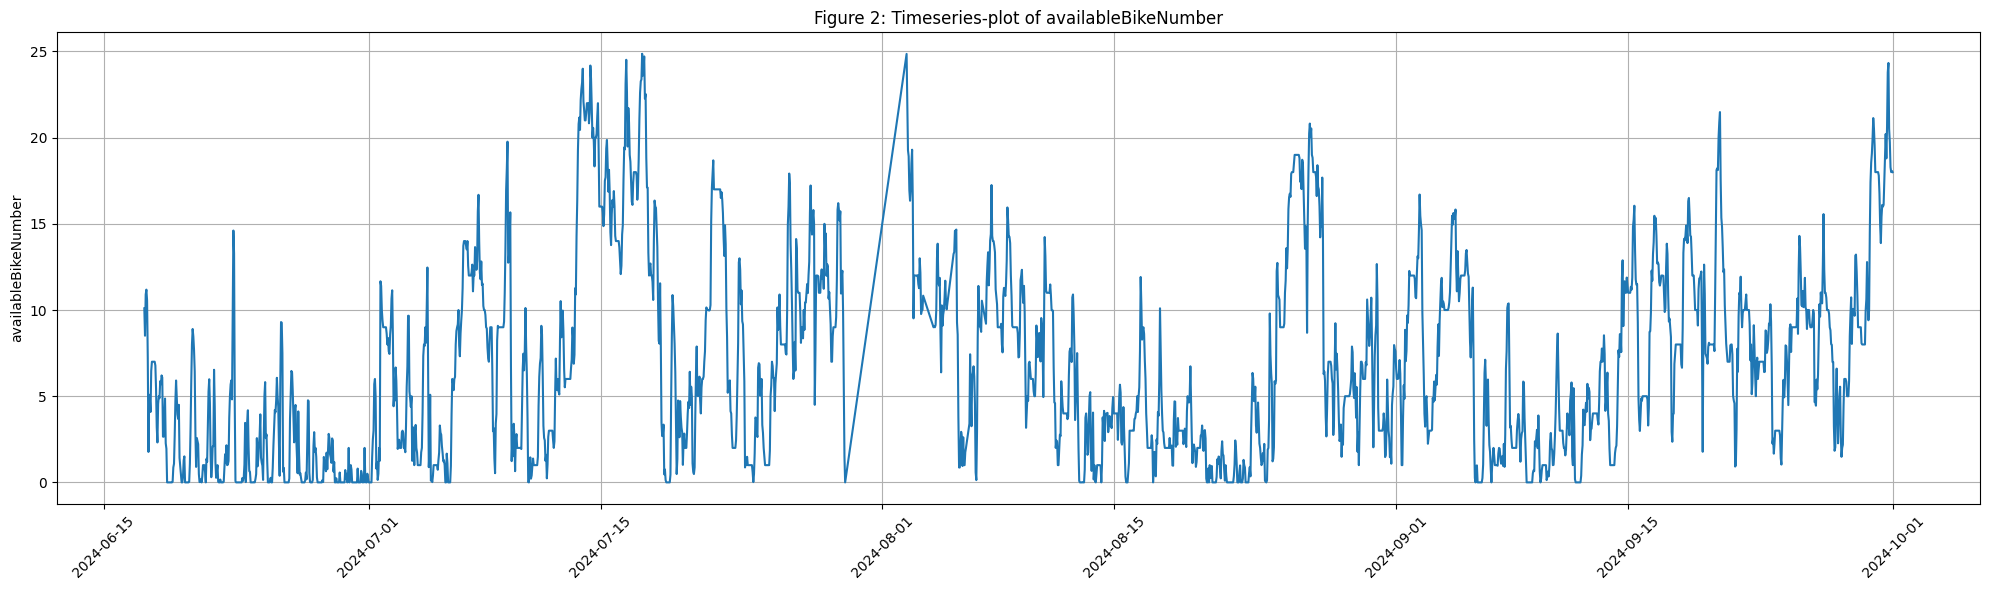

In [362]:
# timeplot
df_plot = df_alter_markt_engineered.copy()

# df_plot['Datetime'] = df_plot['index'] + pd.to_timedelta(df_plot['Hour'], unit='h')

plt.figure(figsize=(20, 6))
plt.plot(df_plot['index'], df_plot['availableBikeNumber'])

plt.title('Figure 2: Timeseries-plot of availableBikeNumber')
# plt.xlabel('Date and Hour')
plt.ylabel('availableBikeNumber')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

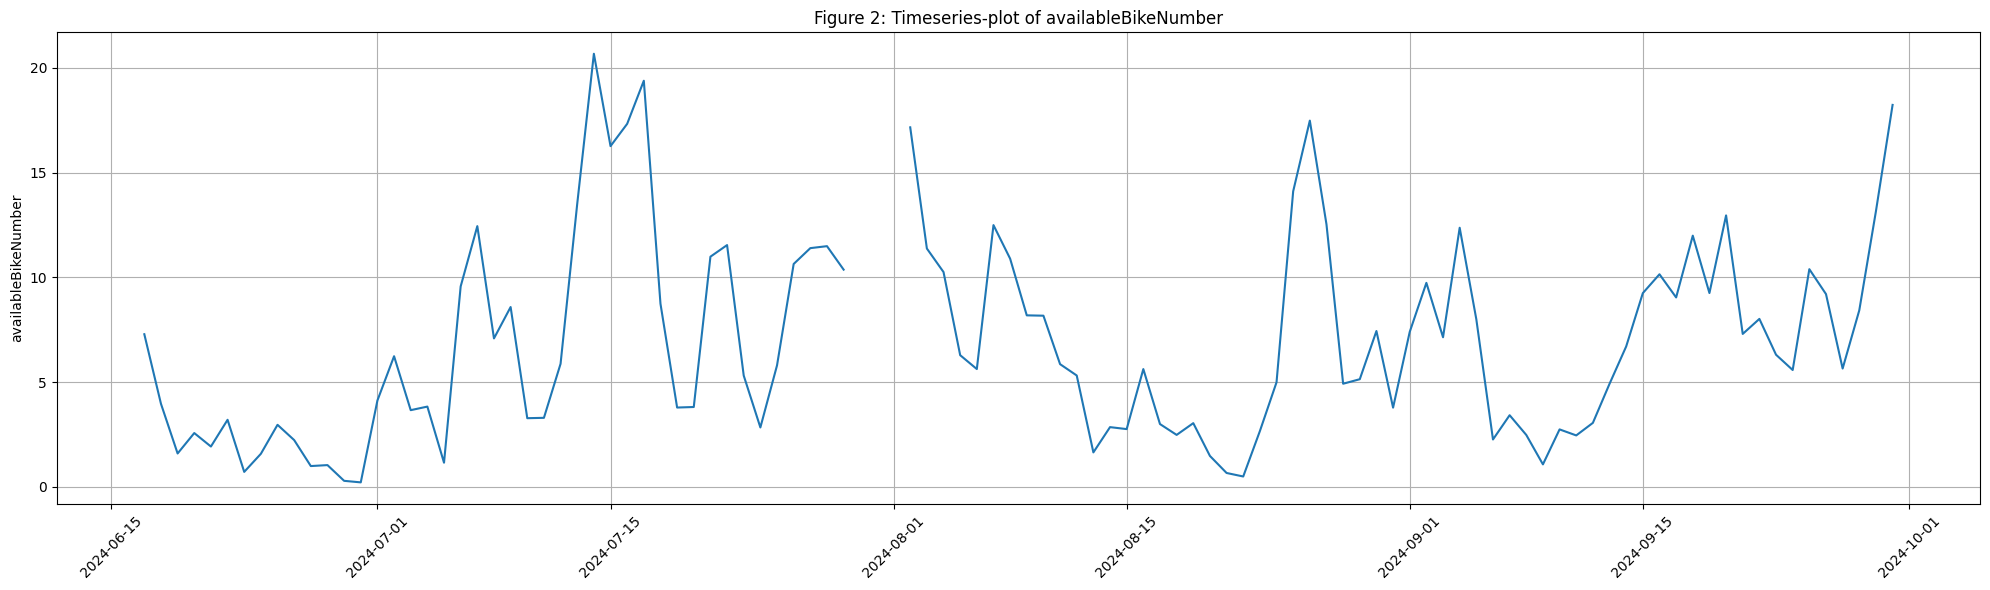

In [363]:
# timeplot

daily_data = df_plot.resample('D', on='index')['availableBikeNumber'].mean()

plt.figure(figsize=(20, 6))
# plt.plot(df_plot['Datetime'], df_plot['Rented Bike Count'])
plt.plot(daily_data.index, daily_data.values)

plt.title('Figure 2: Timeseries-plot of availableBikeNumber')
# plt.xlabel('Date and Hour')
plt.ylabel('availableBikeNumber')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

In [364]:
def draw_heatmap_by_metric_and_feature(dataframe, metric, feature, figure_number):

    # Compute average metric per hour
    pivot = dataframe.pivot_table(index='Hour', columns=feature, values=metric, aggfunc='mean').fillna(0)

    if feature == 'DayOfWeek':
        pivot = pivot.reindex(columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    
    if feature == 'Month':
        pivot = pivot.reindex(columns=['January', 'February', 'March', 'April', 'May', 'June',
                                       'July', 'August', 'September', 'October', 'November', 'December'])
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(pivot, fmt=".0f", cmap='YlGnBu', annot=True, cbar_kws={'label': metric}, linewidths=0.5)
    
    ax.set_title(f'Figure {figure_number}: Heatmap of Average {metric} by Hour and {feature}')
    ax.set_xlabel('')
    ax.set_ylabel('Hour')
    
    plt.tight_layout()
    plt.show()

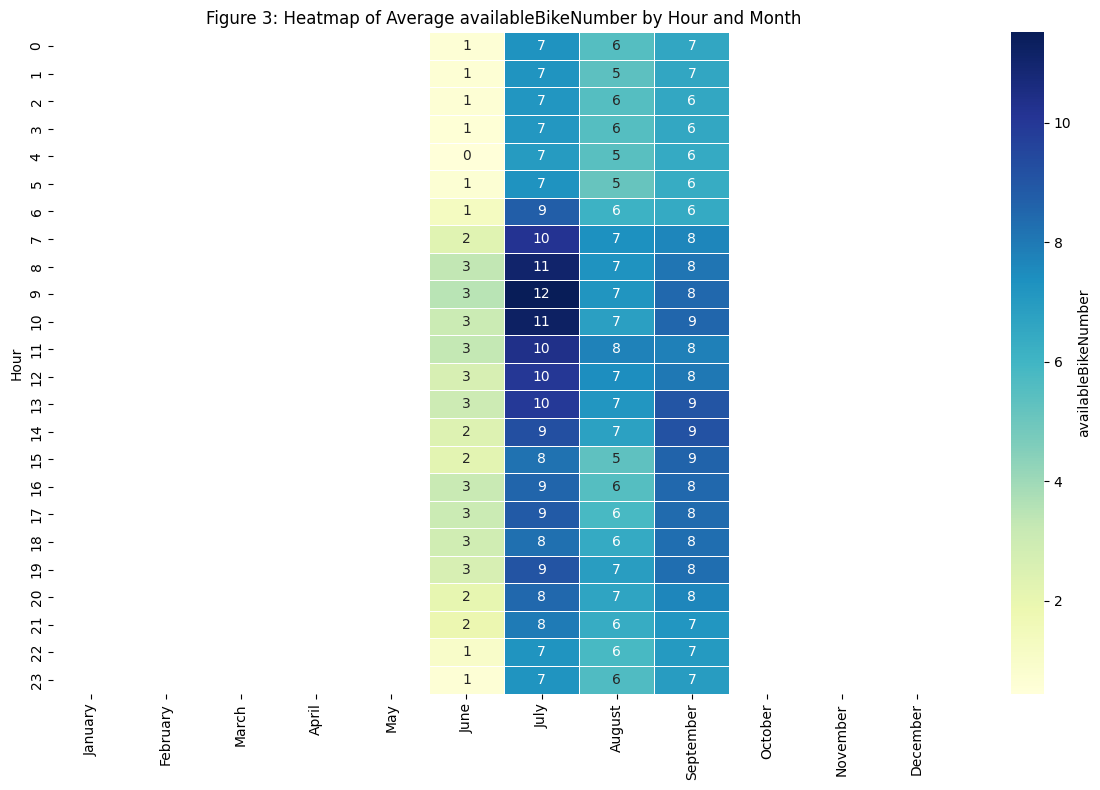

In [365]:
draw_heatmap_by_metric_and_feature(df_plot, 'availableBikeNumber', 'Month', 3)

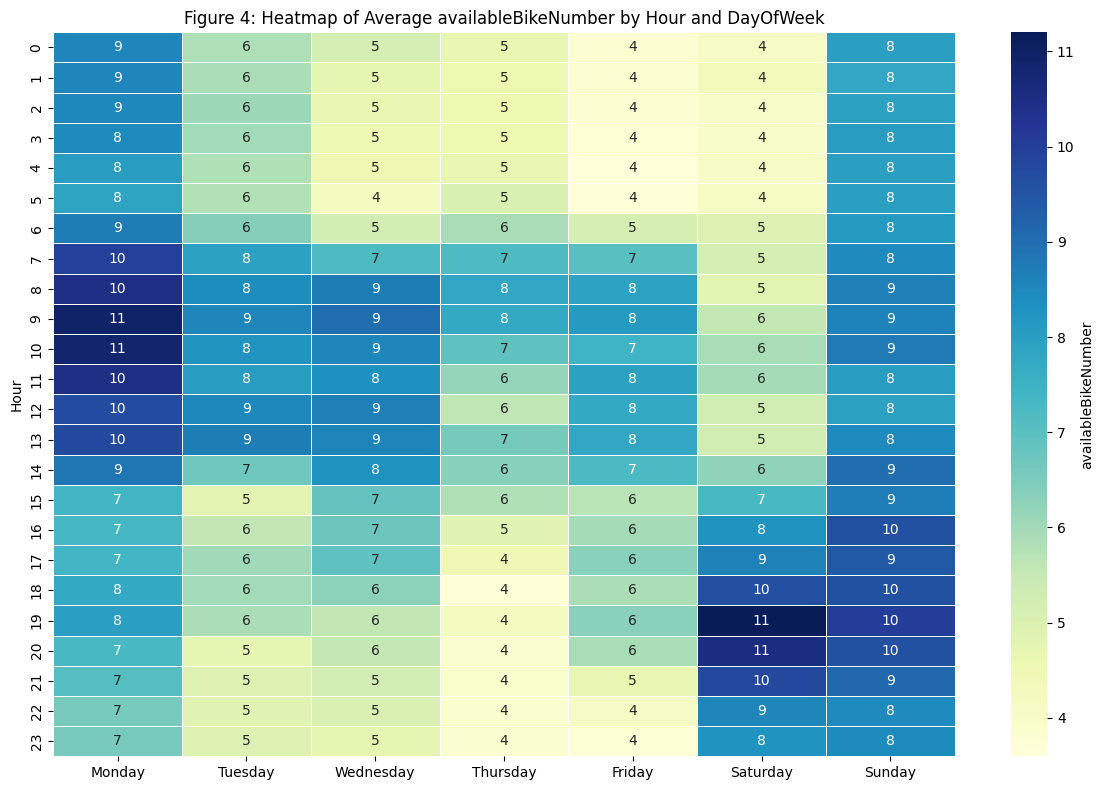

In [366]:
draw_heatmap_by_metric_and_feature(df_plot, 'availableBikeNumber', 'DayOfWeek', 4)

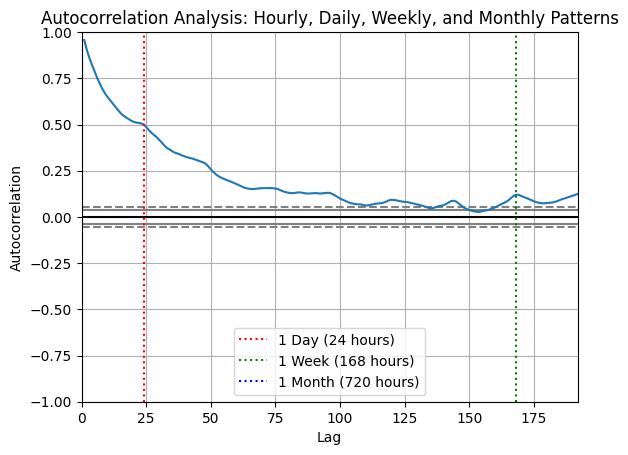

In [368]:
# check for patterns with auto correlation
# make auto correlation
# by hour (done)
# by day
# by month

# Calculate autocorrelation
ax = autocorrelation_plot(df_plot['availableBikeNumber'])
ax.set_title('Autocorrelation Analysis: Hourly, Daily, Weekly, and Monthly Patterns')
ax.set_xlim([0, 24 * 8])  # View up to 30 days for long-term cycles

# Add vertical lines for different periods
plt.axvline(24, linestyle=':', color='r', label='1 Day (24 hours)')
plt.axvline(24*7, linestyle=':', color='g', label='1 Week (168 hours)')
plt.axvline(24*30, linestyle=':', color='b', label='1 Month (720 hours)')

plt.legend()

plt.show()

In [369]:
# make dickey-fuller test for stationary
# test statistic -> timeseries is / is not stationary
# we want stationarity 
# if not we make .diff()
# do fuller test again
# 

def print_ad_fuller(timeseries):
    ad_fuller_res = adfuller(timeseries)
    print('ADF Statistic: %f' % ad_fuller_res[0])
    print('p-value: %f' % ad_fuller_res[1])
    print('Critical Values:')
    for key, value in ad_fuller_res[4].items():
        print('\t%s: %.3f' % (key, value))

In [370]:
print ("Augmented Dickey–Fuller Test for original time series")
print_ad_fuller(df_plot['availableBikeNumber'])

Augmented Dickey–Fuller Test for original time series
ADF Statistic: -4.389913
p-value: 0.000309
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


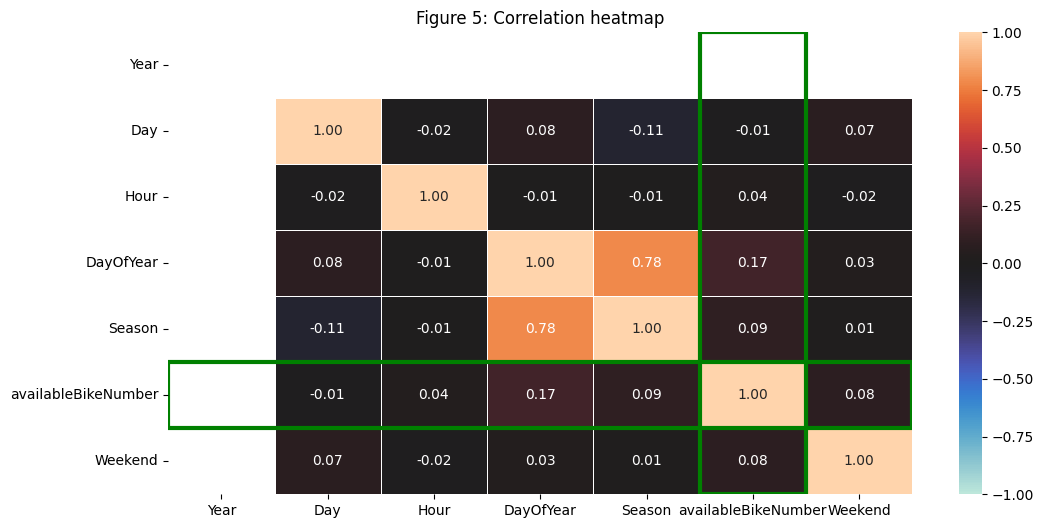

In [371]:
# plot correlation between parameter with sns.heatmap

corrs = df_plot.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(corrs, annot=True, fmt=".2f", ax=ax, linewidth=.5, center=0, vmin=-1, vmax=1)

index = corrs.columns.get_loc('availableBikeNumber')

rect_col = patches.Rectangle((index, 0), 1, corrs.shape[0], linewidth=3, edgecolor='green', facecolor='none')
rect_row = patches.Rectangle((0, index), corrs.shape[1], 1, linewidth=3, edgecolor='green', facecolor='none')

ax.add_patch(rect_col)
ax.add_patch(rect_row)

ax.set_title('Figure 5: Correlation heatmap')
plt.show()

***
## First try

- nur index spalte als nummer umgewandelt

In [16]:
target = df_alter_markt_model.loc[:, ["availableBikeNumber"]]
data = df_alter_markt_model.drop("availableBikeNumber", axis=1)

print(data.shape)
data.head()

(2413, 1)


,index
0,2024-06-17 11:00:00+00:00
1,2024-06-17 12:00:00+00:00
2,2024-06-17 13:00:00+00:00
3,2024-06-17 14:00:00+00:00
4,2024-06-17 15:00:00+00:00


In [17]:
# X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.4, shuffle=True, random_state=1)

train_size = int(len(data) * 0.8)
X_train = data[:train_size]
X_test = data[train_size:]
y_train = target[:train_size]
y_test = target[train_size:]

In [18]:
for i in (X_train, X_test, y_train, y_test):
    print(i.shape)

(1930, 1)
(483, 1)
(1930, 1)
(483, 1)


In [19]:
X_train_processed = X_train['index'].apply(lambda x: x.timestamp()).to_numpy().reshape(-1, 1)
X_test_processed = X_test['index'].apply(lambda x: x.timestamp()).to_numpy().reshape(-1, 1)

In [20]:
y_scaler = MinMaxScaler()
# X_scaler = MinMaxScaler()

# X_train_processed=X_scaler.fit_transform(X_train_processed)
# X_test_processed=X_scaler.transform(X_test_processed)

y_train_sc=y_scaler.fit_transform(y_train)
y_test_sc=y_scaler.transform(y_test)

In [21]:
X_train_tensor=torch.Tensor(X_train_processed)
X_test_tensor=torch.Tensor(X_test_processed)
y_train_tensor=torch.Tensor(y_train_sc)
y_test_tensor=torch.Tensor(y_test_sc)

In [22]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size):
        super(MultiLayerPerceptron, self).__init__()
                
        self.hidden_1 = nn.Linear(input_size, 128)
        self.hidden_2 = nn.Linear(128, 64)
        self.hidden_3 = nn.Linear(64, 32)
        self.output = nn.Linear(32,1)
        self.activation=nn.PReLU()
 
    def forward(self, x):

        out1 = self.activation(self.hidden_1(x))
        out2 = self.activation(self.hidden_2(out1))
        out3 = self.activation(self.hidden_3(out2))
        
        return self.output(out3)

In [23]:
def train_model(model, X_train, y_train, criterion, optimizer, epochs):
    model.train()

    for epoch in range(epochs):
        y_train_pred = model(X_train)
        optimizer.zero_grad()

        train_loss = criterion(y_train_pred, y_train)

        train_loss.backward()

        optimizer.step()

        if (epoch % 100==99):
            print("Epoch: %d, loss: %1.5f" % (epoch, train_loss.item()))

In [24]:
criterion = torch.nn.MSELoss()
learning_rate=0.01
epochs=1000

In [25]:
torch.manual_seed(1)
dummy_model=MultiLayerPerceptron(X_train.shape[1])
optimizer = torch.optim.Adam(dummy_model.parameters(), lr=learning_rate)
train_model(dummy_model, X_train_tensor, y_train_tensor, criterion, optimizer, epochs)

Epoch: 99, loss: 332964986880.00000
Epoch: 199, loss: 5741838.50000
Epoch: 299, loss: 805.20581
Epoch: 399, loss: 656.77136
Epoch: 499, loss: 655.87561
Epoch: 599, loss: 655.87561
Epoch: 699, loss: 655.87561
Epoch: 799, loss: 655.87561
Epoch: 899, loss: 655.87561
Epoch: 999, loss: 655.87561


In [26]:
results = pd.DataFrame()

In [27]:
# Use a dataframe to collect general evaluation results
try:
    results
except NameError:
    results = pd.DataFrame()

dummy_model.eval()
y_train_pred=y_scaler.inverse_transform(mads_dl.predict(dummy_model, X_train_tensor))
y_test_pred=y_scaler.inverse_transform(mads_dl.predict(dummy_model, X_test_tensor))
results = mads_dl.add_regression_eval(results, "first test", 
                   y_train, y_train_pred, 
                   y_test, y_test_pred,
                   mads_dl.count_params(dummy_model)
                  )

In [28]:
# results[results.dataset=="train"]\
# .sort_values("MAPE", ascending=False)\
# .round(2)
results.head()

,algorithm,dataset,MSE,MAE,MAPE,params
0,first test,train,405561.418465,505.024344,2.055359e+19,10626
1,first test,test,403047.858609,510.611464,4.138635e+18,10626


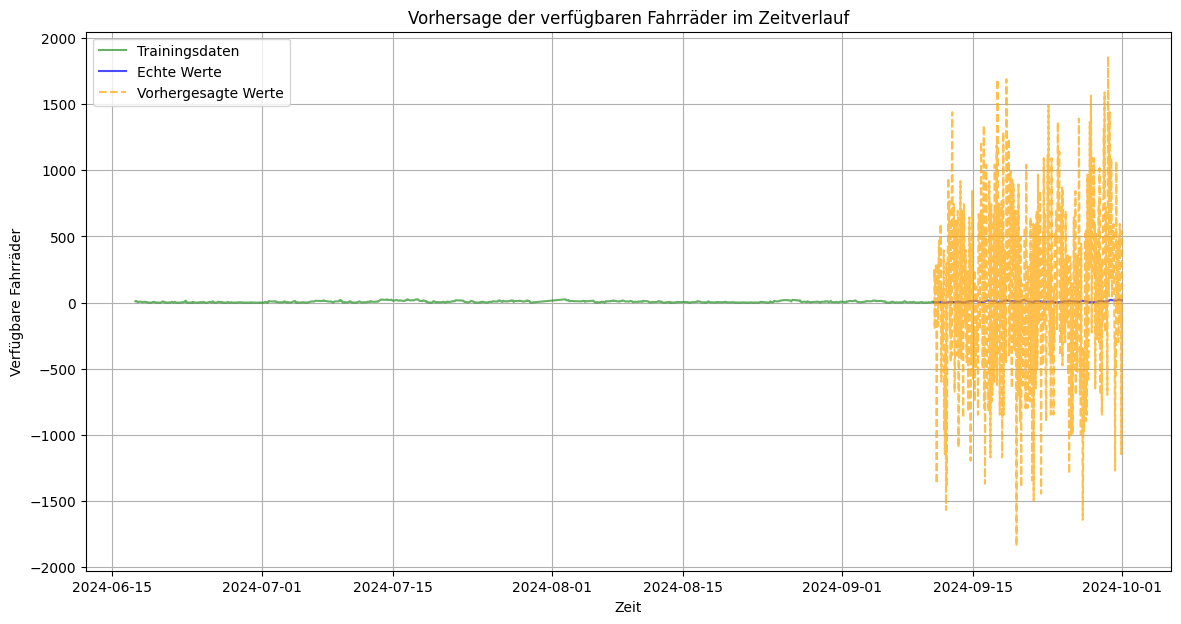

In [29]:
# Plot erstellen
plt.figure(figsize=(14, 7))

# Originale Trainingsdaten markieren (X_train als Zeitdaten)
plt.plot(X_train, y_train, label='Trainingsdaten', color='green', alpha=0.6)

# Originale Daten plotten (aus y_test) gegen die Zeit
plt.plot(X_test, y_test, label='Echte Werte', color='blue', alpha=0.7)

# Vorhergesagte Daten plotten (aus y_predictions_original) gegen die Zeit
plt.plot(X_test, y_test_pred, label='Vorhergesagte Werte', color='orange', linestyle='--', alpha=0.7)

# Zusätzliche Darstellungseinstellungen
plt.title("Vorhersage der verfügbaren Fahrräder im Zeitverlauf")
plt.xlabel("Zeit")
plt.ylabel("Verfügbare Fahrräder")
plt.legend()
plt.grid(True)

# Diagramm anzeigen
plt.show()

## Second try

- mehr spalten, feature engeneering

In [32]:
target = df_alter_markt_model_2_dummified.loc[:, ["availableBikeNumber"]]
data = df_alter_markt_model_2_dummified.drop(['index', 'availableBikeNumber'], axis=1) 

print(data.shape)
data.head()

(2413, 13)


,Year,Month,Day,Hour,Weekend,DayOfYear,Season_4,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,2024,6,17,11,False,169,False,False,False,False,False,False,False
1,2024,6,17,12,False,169,False,False,False,False,False,False,False
2,2024,6,17,13,False,169,False,False,False,False,False,False,False
3,2024,6,17,14,False,169,False,False,False,False,False,False,False
4,2024,6,17,15,False,169,False,False,False,False,False,False,False


In [33]:
# X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.4, shuffle=True, random_state=1)

train_size = int(len(data) * 0.8)
X_train = data[:train_size]
X_test = data[train_size:]
y_train = target[:train_size]
y_test = target[train_size:]

In [34]:
for i in (X_train, X_test, y_train, y_test):
    print(i.shape)

(1930, 13)
(483, 13)
(1930, 1)
(483, 1)


In [35]:
y_scaler = MinMaxScaler()
X_scaler = MinMaxScaler()

X_train_sc = X_scaler.fit_transform(X_train)
X_test_sc = X_scaler.transform(X_test)

y_train_sc = y_scaler.fit_transform(y_train)
y_test_sc = y_scaler.transform(y_test)

In [36]:
X_train_tensor=torch.Tensor(X_train_sc)
X_test_tensor=torch.Tensor(X_test_sc)
y_train_tensor=torch.Tensor(y_train_sc)
y_test_tensor=torch.Tensor(y_test_sc)

In [37]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size):
        super(MultiLayerPerceptron, self).__init__()
                
        self.hidden_1 = nn.Linear(input_size, 128)
        self.hidden_2 = nn.Linear(128, 64)
        self.hidden_3 = nn.Linear(64, 32)
        self.output = nn.Linear(32,1)
        self.activation=nn.PReLU()
 
    def forward(self, x):

        out1 = self.activation(self.hidden_1(x))
        out2 = self.activation(self.hidden_2(out1))
        out3 = self.activation(self.hidden_3(out2))
        
        return self.output(out3)

In [38]:
def train_model(model, X_train, y_train, criterion, optimizer, epochs):
    model.train()

    for epoch in range(epochs):
        y_train_pred = model(X_train)
        optimizer.zero_grad()

        train_loss = criterion(y_train_pred, y_train)

        train_loss.backward()

        optimizer.step()

        if (epoch % 100==99):
            print("Epoch: %d, loss: %1.5f" % (epoch, train_loss.item()))

In [39]:
criterion = torch.nn.MSELoss()
learning_rate=0.01
epochs=1000

In [40]:
torch.manual_seed(1)
dummy_model=MultiLayerPerceptron(X_train.shape[1])
optimizer = torch.optim.Adam(dummy_model.parameters(), lr=learning_rate)
train_model(dummy_model, X_train_tensor, y_train_tensor, criterion, optimizer, epochs)

Epoch: 99, loss: 0.01986
Epoch: 199, loss: 0.00696
Epoch: 299, loss: 0.00594
Epoch: 399, loss: 0.00321
Epoch: 499, loss: 0.00320
Epoch: 599, loss: 0.00308
Epoch: 699, loss: 0.00362
Epoch: 799, loss: 0.00334
Epoch: 899, loss: 0.00141
Epoch: 999, loss: 0.00143


In [41]:
try:
    results
except NameError:
    results = pd.DataFrame()

dummy_model.eval()
y_train_pred=y_scaler.inverse_transform(mads_dl.predict(dummy_model, X_train_tensor))
y_test_pred=y_scaler.inverse_transform(mads_dl.predict(dummy_model, X_test_tensor))
results = mads_dl.add_regression_eval(results, "second test", 
                   y_train, y_train_pred, 
                   y_test, y_test_pred,
                   mads_dl.count_params(dummy_model)
                  )

In [42]:
results.head()

,algorithm,dataset,MSE,MAE,MAPE,params
0,first test,train,405561.418465,505.024344,2.055359e+19,10626
1,first test,test,403047.858609,510.611464,4.138635e+18,10626
2,second test,train,0.831161,0.651325,1.287253e+16,12162
3,second test,test,168.461700,11.649507,4.257067e+16,12162


In [43]:
X_train

,Year,Month,Day,Hour,Weekend,DayOfYear,Season_4,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,2024,6,17,11,False,169,False,False,False,False,False,False,False
1,2024,6,17,12,False,169,False,False,False,False,False,False,False
2,2024,6,17,13,False,169,False,False,False,False,False,False,False
3,2024,6,17,14,False,169,False,False,False,False,False,False,False
4,2024,6,17,15,False,169,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1925,2024,9,10,16,False,254,True,True,False,False,False,False,False
1926,2024,9,10,17,False,254,True,True,False,False,False,False,False
1927,2024,9,10,18,False,254,True,True,False,False,False,False,False
1928,2024,9,10,19,False,254,True,True,False,False,False,False,False


C:\Users\JustusHeilingbrunner\AppData\Local\Temp\ipykernel_20616\4203211030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['datetime'] = pd.to_datetime(X_train[['Year', 'Month', 'Day', 'Hour']])
C:\Users\JustusHeilingbrunner\AppData\Local\Temp\ipykernel_20616\4203211030.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['datetime'] = pd.to_datetime(X_test[['Year', 'Month', 'Day', 'Hour']])


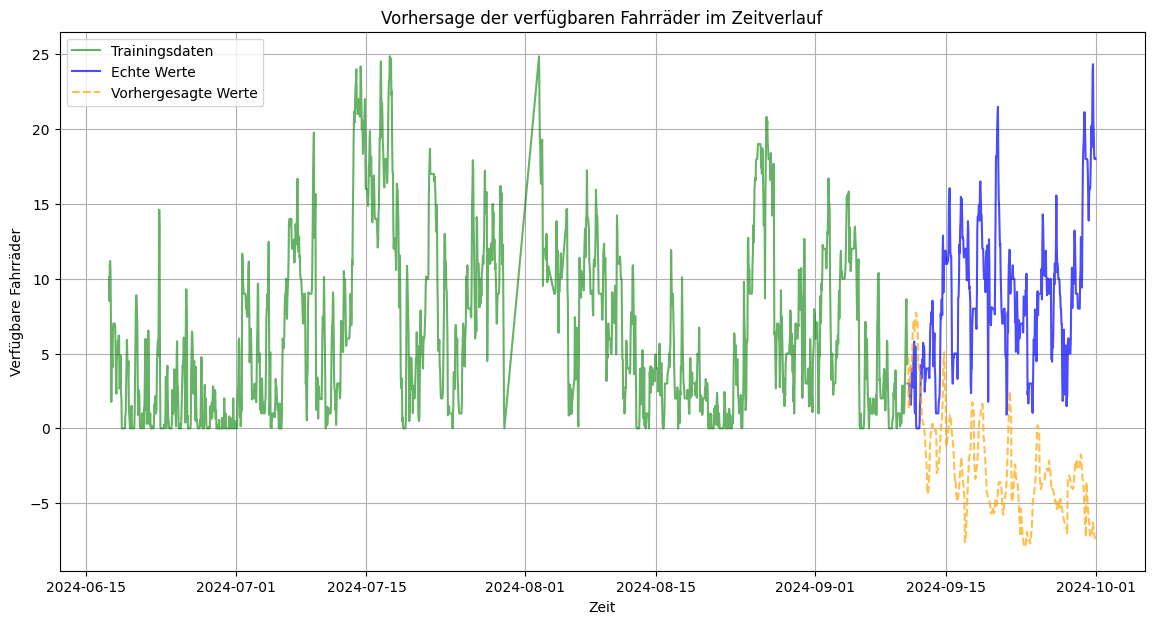

In [44]:
X_train['datetime'] = pd.to_datetime(X_train[['Year', 'Month', 'Day', 'Hour']])
X_test['datetime'] = pd.to_datetime(X_test[['Year', 'Month', 'Day', 'Hour']])

# Plot erstellen
plt.figure(figsize=(14, 7))

# Originale Trainingsdaten markieren
plt.plot(X_train['datetime'], y_train, label='Trainingsdaten', color='green', alpha=0.6)

# Originale Testdaten plotten
plt.plot(X_test['datetime'], y_test, label='Echte Werte', color='blue', alpha=0.7)

# Vorhergesagte Testwerte plotten
plt.plot(X_test['datetime'], y_test_pred, label='Vorhergesagte Werte', color='orange', linestyle='--', alpha=0.7)

# Zusätzliche Darstellungseinstellungen
plt.title("Vorhersage der verfügbaren Fahrräder im Zeitverlauf")
plt.xlabel("Zeit")
plt.ylabel("Verfügbare Fahrräder")
plt.legend()
plt.grid(True)

# Diagramm anzeigen
plt.show()

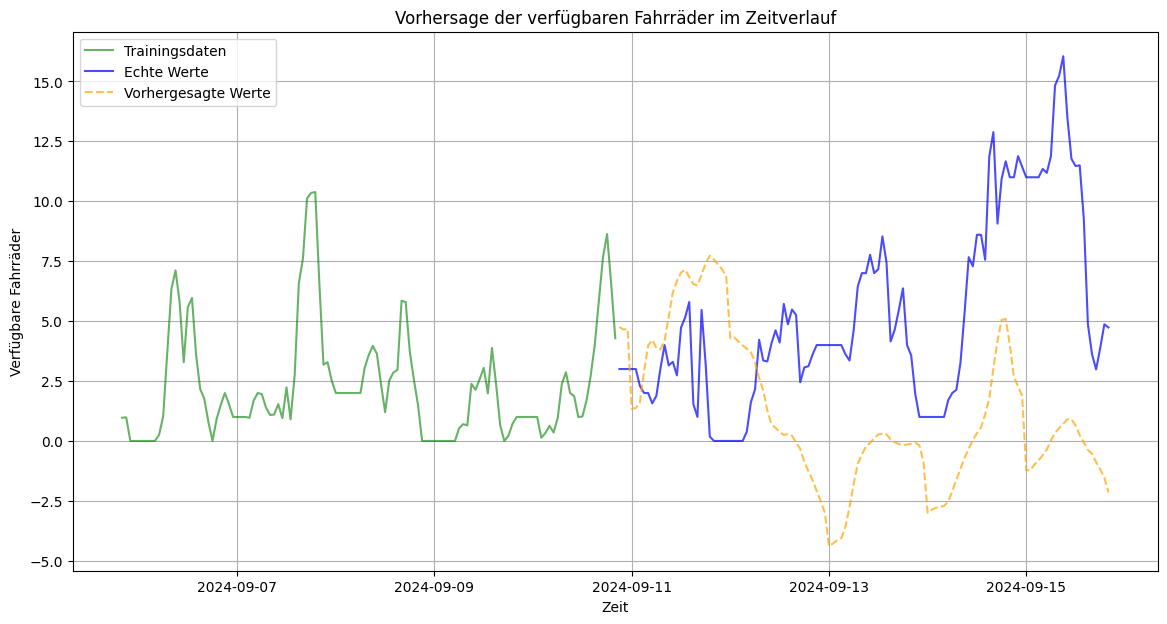

In [45]:
total_points = len(X_train) + len(X_test)

# Calculate indices for 75% and 85% marks
start_index = int(0.75 * total_points)
end_index = int(0.05 * total_points)
# end_index = start_index + end_index

# Plot erstellen
plt.figure(figsize=(14, 7))

# Originale Trainingsdaten markieren
plt.plot(X_train['datetime'].iloc[start_index:], y_train[start_index:], label='Trainingsdaten', color='green', alpha=0.6)

# Originale Testdaten plotten
plt.plot(X_test['datetime'].iloc[:end_index], y_test[:end_index], label='Echte Werte', color='blue', alpha=0.7)

# Vorhergesagte Testwerte plotten
plt.plot(X_test['datetime'].iloc[:end_index], y_test_pred[:end_index], label='Vorhergesagte Werte', color='orange', linestyle='--', alpha=0.7)

# Zusätzliche Darstellungseinstellungen
plt.title("Vorhersage der verfügbaren Fahrräder im Zeitverlauf")
plt.xlabel("Zeit")
plt.ylabel("Verfügbare Fahrräder")
plt.legend()
plt.grid(True)

# Diagramm anzeigen
plt.show()

## Third test

- train test split shuffeld

In [46]:
target = df_alter_markt_model_2_dummified.loc[:, ["availableBikeNumber"]]
data = df_alter_markt_model_2_dummified.drop(['index', 'availableBikeNumber'], axis=1)

print(data.shape)
data.head()

(2413, 13)


,Year,Month,Day,Hour,Weekend,DayOfYear,Season_4,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,2024,6,17,11,False,169,False,False,False,False,False,False,False
1,2024,6,17,12,False,169,False,False,False,False,False,False,False
2,2024,6,17,13,False,169,False,False,False,False,False,False,False
3,2024,6,17,14,False,169,False,False,False,False,False,False,False
4,2024,6,17,15,False,169,False,False,False,False,False,False,False


In [47]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.4, shuffle=True, random_state=1)


In [48]:
for i in (X_train, X_test, y_train, y_test):
    print(i.shape)

(1447, 13)
(966, 13)
(1447, 1)
(966, 1)


In [49]:
y_scaler = MinMaxScaler()
X_scaler = MinMaxScaler()

X_train_sc = X_scaler.fit_transform(X_train)
X_test_sc = X_scaler.transform(X_test)

y_train_sc = y_scaler.fit_transform(y_train)
y_test_sc = y_scaler.transform(y_test)

In [50]:
X_train_tensor=torch.Tensor(X_train_sc)
X_test_tensor=torch.Tensor(X_test_sc)
y_train_tensor=torch.Tensor(y_train_sc)
y_test_tensor=torch.Tensor(y_test_sc)

In [51]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size):
        super(MultiLayerPerceptron, self).__init__()
                
        self.hidden_1 = nn.Linear(input_size, 128)
        self.hidden_2 = nn.Linear(128, 64)
        self.hidden_3 = nn.Linear(64, 32)
        self.output = nn.Linear(32,1)
        self.activation=nn.PReLU()
 
    def forward(self, x):

        out1 = self.activation(self.hidden_1(x))
        out2 = self.activation(self.hidden_2(out1))
        out3 = self.activation(self.hidden_3(out2))
        
        return self.output(out3)

In [52]:
def train_model(model, X_train, y_train, criterion, optimizer, epochs):
    model.train()

    for epoch in range(epochs):
        y_train_pred = model(X_train)
        optimizer.zero_grad()

        train_loss = criterion(y_train_pred, y_train)

        train_loss.backward()

        optimizer.step()

        if (epoch % 100==99):
            print("Epoch: %d, loss: %1.5f" % (epoch, train_loss.item()))

In [53]:
criterion = torch.nn.MSELoss()
learning_rate=0.01
epochs=1000

In [54]:
torch.manual_seed(1)
dummy_model=MultiLayerPerceptron(X_train.shape[1])
optimizer = torch.optim.Adam(dummy_model.parameters(), lr=learning_rate)
train_model(dummy_model, X_train_tensor, y_train_tensor, criterion, optimizer, epochs)

Epoch: 99, loss: 0.02755
Epoch: 199, loss: 0.01004
Epoch: 299, loss: 0.00458
Epoch: 399, loss: 0.00322
Epoch: 499, loss: 0.00287
Epoch: 599, loss: 0.00228
Epoch: 699, loss: 0.00174
Epoch: 799, loss: 0.00267
Epoch: 899, loss: 0.00134
Epoch: 999, loss: 0.00178


In [55]:
try:
    results
except NameError:
    results = pd.DataFrame()

dummy_model.eval()
y_train_pred=y_scaler.inverse_transform(mads_dl.predict(dummy_model, X_train_tensor))
y_test_pred=y_scaler.inverse_transform(mads_dl.predict(dummy_model, X_test_tensor))
results = mads_dl.add_regression_eval(results, "third test", 
                   y_train, y_train_pred, 
                   y_test, y_test_pred,
                   mads_dl.count_params(dummy_model)
                  )

In [56]:
results.head(6)

,algorithm,dataset,MSE,MAE,MAPE,params
0,first test,train,405561.418465,505.024344,2.055359e+19,10626
1,first test,test,403047.858609,510.611464,4.138635e+18,10626
2,second test,train,0.831161,0.651325,1.287253e+16,12162
3,second test,test,168.461700,11.649507,4.257067e+16,12162
4,third test,train,1.023896,0.777296,1.922833e+16,12162
5,third test,test,2.828815,1.209526,2.586745e+16,12162


In [57]:
X_train

,Year,Month,Day,Hour,Weekend,DayOfYear,Season_4,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
982,2024,7,28,9,True,210,False,False,False,False,False,False,True
1418,2024,8,20,13,False,233,False,True,False,False,False,False,False
1593,2024,8,27,20,False,240,False,True,False,False,False,False,False
1759,2024,9,3,18,False,247,True,True,False,False,False,False,False
1713,2024,9,1,20,True,245,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,2024,7,27,11,True,209,False,False,False,False,False,True,False
905,2024,7,25,4,False,207,False,False,False,True,False,False,False
1096,2024,8,6,22,False,219,False,True,False,False,False,False,False
235,2024,6,27,6,False,179,False,False,False,True,False,False,False


In [58]:
# wie kann man das besser darstellen. ich möchte die trainings und test daten verbinden und die predictions

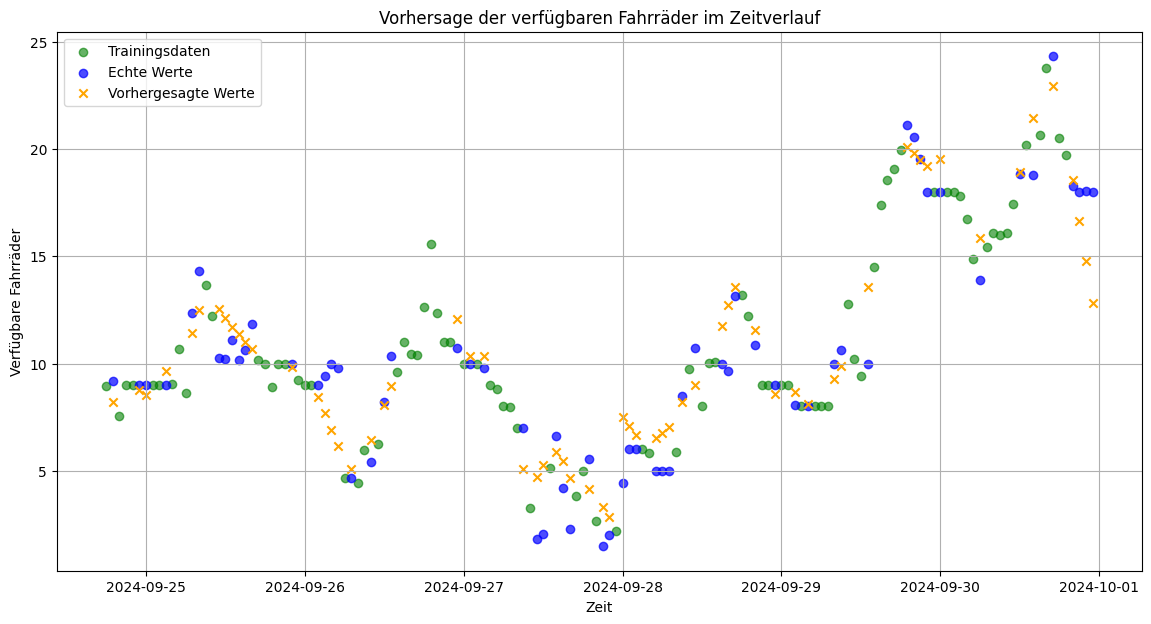

In [59]:
X_train['datetime'] = pd.to_datetime(X_train[['Year', 'Month', 'Day', 'Hour']])
X_test['datetime'] = pd.to_datetime(X_test[['Year', 'Month', 'Day', 'Hour']])

# Kombiniere Train und Test für das Sortieren, getrennte Analyse aber weiterhin möglich
# combined = pd.concat([X_train, X_test])
# combined['target_train'] = pd.concat([y_train])
# combined['target_test'] = pd.concat([y_test])

# combined_sorted = combined.sort_values(by='datetime')

combined_train = X_train.copy()
combined_train['target_train'] = y_train
combined_test = X_test.copy()
combined_test['target_test'] = y_test
combined_test['pred'] = y_test_pred

combined_sorted = pd.concat([combined_train, combined_test]).sort_values(by='datetime')

last_x_points = combined_sorted.tail(150)

# Plot erstellen
plt.figure(figsize=(14, 7))

# Originale Trainingsdaten markieren
# plt.scatter(last_x_points['datetime'], last_x_points['target_train'], label='Trainingsdaten', color='green', alpha=0.6)
plt.scatter(last_x_points['datetime'], last_x_points['target_train'], label='Trainingsdaten', color='green', alpha=0.6)

# Originale Testdaten plotten
# plt.scatter(last_x_points['datetime'], last_x_points['target_test'], label='Echte Werte', color='blue', alpha=0.7)
plt.scatter(last_x_points['datetime'], last_x_points['target_test'], color='blue', alpha=0.7, label='Echte Werte')

# Vorhergesagte Testwerte plotten
# plt.plot(combined_sorted['datetime'], combined_sorted['pred'], label='Vorhergesagte Werte', color='orange', linestyle='--', alpha=0.7)
plt.scatter(last_x_points['datetime'], last_x_points['pred'], label='Vorhergesagte Werte', color='orange', marker='x')

# Zusätzliche Darstellungseinstellungen
plt.title("Vorhersage der verfügbaren Fahrräder im Zeitverlauf")
plt.xlabel("Zeit")
plt.ylabel("Verfügbare Fahrräder")
plt.legend()
plt.grid(True)

# Diagramm anzeigen
plt.show()

***
## test 4 timeseries aus vorlesung

### functions

In [457]:
def count_params(model):
    '''
    Return the number of trainable parameters of a PyTorch Module (model)
    Iterate each of the modules parameters and counts them 
    if they require grad (if they are trainable)
    '''
    if isinstance(model, nn.Module):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return 0

In [470]:
# Add evaluation measures to the dataframe result_df
# NOTE: At this stage, we are working with a differenced time series, thus metrics like mape make no sense!
def add_result(result_df, predictions, model, model_name, criterion, scaler, testY_pred, testY, trainY_pred, trainY, training_time):
    # Check if index entries for the model and datasets exist, otherwise add them
    if (model_name, 'Train') not in result_df.index:
        result_df.loc[(model_name, 'Train'), :] = [np.nan] * len(result_df.columns)
    if (model_name, 'Test') not in result_df.index:
        result_df.loc[(model_name, 'Test'), :] = [np.nan] * len(result_df.columns)
    
    # Train
    # compute loss as the difference between predicted and actual number of available bikes 
    trainY_pred_bikes = scaler.inverse_transform(trainY_pred.reshape(-1, 1))
    trainY_bikes = scaler.inverse_transform(trainY.reshape(-1, 1))
    abs_passenger_diff = np.sum(abs(trainY_pred_bikes - trainY_bikes))

    result_df.loc[(model_name, 'Train'), 'Loss'] = criterion(trainY_pred, trainY).item() # compute the loss using the given criterion
    result_df.loc[(model_name, 'Train'), "MSE"] = mean_squared_error(trainY, trainY_pred)
    result_df.loc[(model_name, 'Train'), "MAE"] = mean_absolute_error(trainY, trainY_pred)
    result_df.loc[(model_name, 'Train'), "MAPE"] = mean_absolute_percentage_error(trainY, trainY_pred) * 100 # implemented is relative to 1 not to 100
    result_df.loc[(model_name, 'Train'), "Avg. monthly available bike number deviation"] = round(abs_passenger_diff/len(trainY_bikes), 1)
    result_df.loc[(model_name, 'Train'), "Parameters"] = int(count_params(model))
    result_df.loc[(model_name, 'Train'), "Training_Time_in_sec"] = round(training_time)

    # Test
    # compute loss as the difference between predicted and actual number of available bikes 
    testY_pred_bikes = scaler.inverse_transform(testY_pred.reshape(-1, 1))
    testY_bikes = scaler.inverse_transform(testY.reshape(-1, 1))
    abs_passenger_diff = np.sum(abs(testY_pred_bikes - testY_bikes))

    result_df.loc[(model_name, 'Test'), 'Loss'] = criterion(testY_pred, testY).item() # compute the loss using the given criterion
    result_df.loc[(model_name, 'Test'), "MSE"] = mean_squared_error(testY, testY_pred)
    result_df.loc[(model_name, 'Test'), "MAE"] = mean_absolute_error(testY, testY_pred)
    result_df.loc[(model_name, 'Test'), "MAPE"] = mean_absolute_percentage_error(testY, testY_pred) * 100 # implemented is relative to 1 not to 100
    result_df.loc[(model_name, 'Test'), "Avg. monthly available bike number deviation"] = round(abs_passenger_diff/len(testY_bikes), 1)
    result_df.loc[(model_name, 'Test'), "Parameters"] = int(count_params(model))


    prediction_df = pd.DataFrame(testY_pred_bikes, columns=[model_name])
    if (predictions.empty):
        predictions.reindex_like(prediction_df)
        predictions["actual"] = pd.DataFrame(testY_bikes, columns=["actual"])["actual"]
    predictions[model_name] = prediction_df[model_name]

    print('--Training time: ', round(training_time), 'seconds')
    print(f'Added results for {model_name} to dataframe.')

In [459]:
# create sliding windows with according target variables
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [460]:
# create the machine learning experimental setup (scale data, create sliding windows, split into train-, validation-, and test-data
def setup_experiment(dataset, seq_len, test_share, val_share, scaler):
    scaled_data = scaler.fit_transform(dataset)
    
    x, y = sliding_windows(scaled_data, seq_len)
    used_vec_length = len(y)

    test_size = int(used_vec_length * test_share)
    val_size = int(used_vec_length * val_share)
    train_size = used_vec_length-test_size-val_size
    index_val_start = train_size
    index_test_start = train_size+val_size

    x_train = x[0:index_val_start]
    y_train = y[0:index_val_start]
    x_val = x[index_val_start:index_test_start]
    y_val = y[index_val_start:index_test_start]
    x_test = x[index_test_start:used_vec_length]
    y_test = y[index_test_start:used_vec_length]
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [461]:
# Predict the average of the most recent n elements of x
def baseline_avg_pred_n_steps(x, n):
    return torch.Tensor(np.sum(x[:,-n:], axis=1)/n)

# Predict the value of last n hours
def baseline_last_n_steps(x, n):
    return torch.Tensor(x[:,-n])

# Predict 0 as new value
def baseline_zero(x, scaler):
    return torch.Tensor(np.full((len(x),1), scaler.transform(np.array(0).reshape(-1,1))))

In [462]:
# Train a model using training data
# Evaluate on validation data
# store a checkpoint for the configuration that performed best on validation 
def train(model, num_epochs, learning_rate, loss_function, trainX, trainY, valX, valY):
    optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_val_loss=float("inf")
    best_model_dict=model.state_dict()
    best_epoch=0
    
    model.train()
    
    for epoch in range(num_epochs):
        trainY_pred = model(trainX)  # predict train with the current model
        optimizer.zero_grad()
    
        train_loss = loss_function(trainY_pred, trainY) # compute the loss ("how bad is our model?")
    
        train_loss.backward() # propagate the loss backwards through the network
    
        optimizer.step() # update weights and biases
    
        with torch.no_grad():
            valY_pred=model(valX)
            val_loss=loss_function(valY_pred,valY)
            if (val_loss<best_val_loss):
                best_val_loss=val_loss
                best_model_dict=copy.deepcopy(model.state_dict())
                best_epoch=epoch
            
        if epoch % 1000 == 999:
            print("Epoch: %d, loss: %1.5f, val_loss: %1.5f" % (epoch, train_loss.item(), val_loss.item()))
    model.load_state_dict(best_model_dict)
    print("Best Epoch: %d, loss: %1.5f" % (best_epoch, best_val_loss.item()))
    return model

In [463]:
# Use the model to predict for the values in the test set
# Return the prediction
def predict(model, testX):
    model.eval()
    with torch.no_grad():
        return model(testX)

### model evaluation df_alter_markt, sliding_window = 48, 24

In [525]:
print(df_alter_markt.shape)
df_alter_markt.head()

(2413, 2)


,index,availableBikeNumber
0,2024-06-17 11:00:00+00:00,10.098361
1,2024-06-17 12:00:00+00:00,8.508475
2,2024-06-17 13:00:00+00:00,10.898305
3,2024-06-17 14:00:00+00:00,11.181818
4,2024-06-17 15:00:00+00:00,10.555556


In [526]:
target = df_alter_markt.loc[:, ["availableBikeNumber"]]
data = df_alter_markt.drop(['index', 'availableBikeNumber'], axis=1)

print('Mean of availableBikeNumber: ', np.sum(target['availableBikeNumber'])/len(target))
full_dataset = target['availableBikeNumber'].values.reshape(-1,1) # reshape because the scaler expects a 2D array

Mean of availableBikeNumber:  6.812880388077202


In [527]:
datasetname = 'df_alter_markt'

sc = MinMaxScaler()
criterion = nn.MSELoss() # loss function: mean-squared error for regression
activation = torch.nn.ReLU()
sliding_window_width = 24 # sliding window width is actually a hyperparameter of the training setup

x_train, y_train, x_val, y_val, x_test, y_test = setup_experiment(
    dataset = full_dataset, 
    seq_len = sliding_window_width, # sliding window width = 48 hours
    test_share = 0.2, 
    val_share = 0.2, 
    scaler = sc)

trainX=torch.Tensor(x_train)
trainY=torch.Tensor(y_train)
valX=torch.Tensor(x_val)
valY=torch.Tensor(y_val)
testX=torch.Tensor(x_test)
testY=torch.Tensor(y_test)

print(datasetname)
print('')
print('Dataset Shape: ', full_dataset.shape)
print('Scaler: ', sc)
print('Loss Function (criterion): ', criterion)
print('Activation Function: ', activation)
print('Sliding Window Width: ', sliding_window_width)
print('-----------------')
print('x_train.shape: ', x_train.shape, ', y_train.shape: ', y_train.shape)
print('x_test.shape: ', x_test.shape, ', y_test.shape: ', y_test.shape)
print('-----------------')
print("Dataset shape: ", full_dataset.shape)
print("Training shape: ", trainX.shape, trainY.shape)
print("Validation shape: ", valX.shape, valY.shape)
print("Testset shape: ", testX.shape, testY.shape)

predictions = pd.DataFrame()         # in this dictionary we will store the actual predictions for each model on the test data
result = pd.DataFrame()  # in this dataframe we will store the results of our methods on the test data

index = pd.MultiIndex.from_product([['avg_last_24_hours'], ['Train', 'Test']], names=['Model', 'Dataset'])
result = pd.DataFrame(columns=['Loss', 'MSE', 'MAE', 'MAPE'], index=index)

print('-----------------')
print('-----------------')
print('Doing Baselines')

testY_pred = baseline_avg_pred_n_steps(x_test, 24)
trainY_pred = baseline_avg_pred_n_steps(x_train, 24)
add_result(result, predictions, None, "avg_last_24_hours", criterion, sc, testY_pred, testY, trainY_pred, trainY, 0)

testY_pred = baseline_last_n_steps(x_test, 24)
trainY_pred = baseline_last_n_steps(x_train, 24)
add_result(result, predictions, None, "last_day", criterion, sc, testY_pred, testY, trainY_pred, trainY, 0)

testY_pred = baseline_zero(x_test, sc)
trainY_pred = baseline_zero(x_train, sc)
add_result(result, predictions, None, "no-change", criterion, sc, testY_pred, testY, trainY_pred, trainY, 0)

print('-----------------')
print('Doing MLP')

# Training parameters
num_epochs = 10000
learning_rate = 0.1

# Model hyperparameters
input_size = sliding_window_width
hidden_size = 6

class Perceptron(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(Perceptron, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 1)

 
    def forward(self, x):  # x shape (dataset, time-steps, features)
        x=x.squeeze(-1)    # x shape (dataset, time-steps)
        
        hidden_layer_output = activation(self.hidden_layer(x))  #relu: x>0 -> x, x<=0 -> 0
        
        return self.output_layer(hidden_layer_output)
    
print('--Traing parameters')
print('num_epochs: ', num_epochs)
print('learning_rate: ', learning_rate)
print('--Model hyperparameters')
print('input_size: ', input_size)
print('hidden_size: ', hidden_size)
print('--Training...')

perceptron_model = Perceptron(input_size, hidden_size)

start_time = time.time()
perceptron_model = train(perceptron_model, num_epochs, learning_rate, criterion, trainX, trainY, valX, valY)
training_time = time.time() - start_time

testY_pred = predict(perceptron_model, testX)
trainY_pred = predict(perceptron_model, trainX)
add_result(result, predictions, perceptron_model, "MLP", criterion, sc, testY_pred, testY, trainY_pred, trainY, training_time)

print('-----------------')
print('Doing CNN')

# Training parameters
num_epochs = 10000
learning_rate = 0.01

# Model hyperparameters
input_size = sliding_window_width
out_channels = 2
kernel_size = 4
stride = 2

class ConvModel(nn.Module):

    def __init__(self, input_size, out_channels, kernel_size, stride):
        super(ConvModel, self).__init__()
        
        self.input_size = input_size # size of features
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride=stride
        
        self.conv1d = nn.Conv1d(1, out_channels, kernel_size, stride=stride)
        
        self.conv1d_output_size=out_channels*math.floor((input_size-kernel_size)/stride +1)
        
        self.hidden_layer_size=int(self.conv1d_output_size/2)
        self.lin = nn.Linear(self.conv1d_output_size, self.hidden_layer_size)  
        self.lin2 = nn.Linear(self.hidden_layer_size, 1)  
        
        
    def forward(self, x):
        x_conv_output = activation(self.conv1d(x))
        x_reshape = x_conv_output.reshape(x_conv_output.size(0), -1)
        x_lin1 = activation(self.lin(x_reshape))
        return self.lin2(x_lin1)
    
print('--Traing parameters')
print('num_epochs: ', num_epochs)
print('learning_rate: ', learning_rate)
print('--Model hyperparameters')
print('input_size: ', input_size)
print('out_channels: ', out_channels)
print('kernel_size: ', kernel_size)
print('stride: ', stride)
print('--Training...')

cnn_model = ConvModel(input_size, out_channels, kernel_size, stride)

start_time = time.time()
cnn_model = train(cnn_model, num_epochs, learning_rate, criterion, trainX.permute(0,2,1), trainY, valX.permute(0,2,1), valY)
training_time = time.time() - start_time

testY_pred = predict(cnn_model, testX.permute(0,2,1))
trainY_pred = predict(cnn_model, trainX.permute(0,2,1))
add_result(result, predictions, cnn_model, "CNN", criterion, sc, testY_pred, testY, trainY_pred, trainY, training_time)

print('-----------------')
print('Doing LSTM')

# Training parameters
num_epochs = 5000
learning_rate = 0.02

# Model hyperparameters
input_size = 1
hidden_size = 2

class LstmModel(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(LstmModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(
            input_size=input_size,       # number of features of each input
            hidden_size=hidden_size,     # size of the hidden state and the cell state
            batch_first=True)            # input and output as (batch, seq, feature)

        self.output_layer = nn.Linear(hidden_size, 1)  
        
        
    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size)  # initialize hidden state before each pass
        
        c_0 = torch.zeros(1, x.size(0), self.hidden_size)  # initialize cell state before each pass
        
        lstm_output, (h_out, c_out) = self.lstm(x, (h_0, c_0))  # lstm_output (batch,time-steps,hidden_size), h_out (layers,batch,hidden_size)
        return self.output_layer(lstm_output[:,-1,:])  # use only output of last time step
    
print('--Traing parameters')
print('num_epochs: ', num_epochs)
print('learning_rate: ', learning_rate)
print('--Model hyperparameters')
print('input_size: ', input_size)
print('hidden_size: ', hidden_size)
print('--Training...')

lstm_model = LstmModel(input_size, hidden_size)

start_time = time.time()
lstm_model = train(lstm_model, num_epochs, learning_rate, criterion, trainX, trainY, valX, valY)
training_time = time.time() - start_time

testY_pred = predict(lstm_model, testX)
trainY_pred = predict(lstm_model, trainX)
add_result(result, predictions, lstm_model, "LSTM", criterion, sc, testY_pred, testY, trainY_pred, trainY, training_time)

print('-----------------')
print('Doing GRU')

# Training parameters
num_epochs = 5000
learning_rate = 0.02

# Model hyperparameters
input_size = 1
hidden_size = 2

class GruModel(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(GruModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.gru = nn.GRU(
            input_size=input_size,       # number of features of each input
            hidden_size=hidden_size,     # size of the hidden state and the cell state
            batch_first=True)            # input and output as (batch, seq, feature)

        self.output_layer = nn.Linear(hidden_size, 1)  
        
        
    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size)  # initialize hidden state before each pass
                
        gru_out, h_out = self.gru(x, h_0)  # lstm_output (batch,time-steps,hidden_size), h_out (layers,batch,hidden_size)
        return self.output_layer(gru_out[:,-1,:])  # use only output of last time step
    
print('--Traing parameters')
print('num_epochs: ', num_epochs)
print('learning_rate: ', learning_rate)
print('--Model hyperparameters')
print('input_size: ', input_size)
print('hidden_size: ', hidden_size)
print('--Training...')

gru_model = GruModel(input_size, hidden_size)

start_time = time.time()
gru_model = train(gru_model, num_epochs, learning_rate, criterion, trainX, trainY, valX, valY)
training_time = time.time() - start_time

testY_pred = predict(gru_model, testX)
trainY_pred = predict(gru_model, trainX)
add_result(result, predictions, gru_model, "GRU", criterion, sc, testY_pred, testY, trainY_pred, trainY, training_time)



predictions_df_alter_markt = predictions.copy()
result_df_alter_markt = result.copy()

df_alter_markt

Dataset Shape:  (2413, 1)
Scaler:  MinMaxScaler()
Loss Function (criterion):  MSELoss()
Activation Function:  ReLU()
Sliding Window Width:  24
-----------------
x_train.shape:  (1434, 24, 1) , y_train.shape:  (1434, 1)
x_test.shape:  (477, 24, 1) , y_test.shape:  (477, 1)
-----------------
Dataset shape:  (2413, 1)
Training shape:  torch.Size([1434, 24, 1]) torch.Size([1434, 1])
Validation shape:  torch.Size([477, 24, 1]) torch.Size([477, 1])
Testset shape:  torch.Size([477, 24, 1]) torch.Size([477, 1])
-----------------
-----------------
Doing Baselines
--Training time:  0 seconds
Added results for avg_last_24_hours to dataframe.
--Training time:  0 seconds
Added results for last_day to dataframe.
--Training time:  0 seconds
Added results for no-change to dataframe.
-----------------
Doing MLP
--Traing parameters
num_epochs:  10000
learning_rate:  0.1
--Model hyperparameters
input_size:  24
hidden_size:  6
--Training...
Epoch: 999, loss: 0.00432, val_loss: 0.00352
Epoc

results

In [528]:
result_df_alter_markt.xs('Train', level='Dataset').sort_values(by='Loss').head(20)

,Loss,MSE,MAE,MAPE,Avg. monthly available bike number deviation,Parameters,Training_Time_in_sec
Model,,,,,,,
CNN,0.004008,0.004008,0.040894,1046796881100800.0,1.0,275.0,17.0
MLP,0.004327,0.004327,0.041567,835922165760000.0,1.0,157.0,6.0
GRU,0.004368,0.004368,0.041993,1038495095193600.0,1.0,33.0,78.0
LSTM,0.004383,0.004383,0.04169,1064420822220800.0,1.0,43.0,47.0
avg_last_24_hours,0.021685,0.021685,0.110414,3889118891212800.0,2.7,0.0,0.0
last_day,0.047007,0.047007,0.155865,3320918415769600.0,3.9,0.0,0.0
no-change,0.119721,0.119721,0.25327,89.748955,6.3,0.0,0.0


In [529]:
result_df_alter_markt.xs('Test', level='Dataset').sort_values(by='Loss').head(20)

,Loss,MSE,MAE,MAPE,Avg. monthly available bike number deviation,Parameters,Training_Time_in_sec
Model,,,,,,,
CNN,0.003316,0.003316,0.039656,127954898124800.0,1.0,275.0,NaN
LSTM,0.003335,0.003335,0.038992,132314654310400.0,1.0,43.0,NaN
GRU,0.003376,0.003376,0.03942,142850549350400.0,1.0,33.0,NaN
MLP,0.003417,0.003417,0.039905,103594904780800.0,1.0,157.0,NaN
avg_last_24_hours,0.023198,0.023198,0.120098,768873070592000.0,3.0,0.0,NaN
last_day,0.051498,0.051498,0.182414,894974086348800.0,4.5,0.0,NaN
no-change,0.155986,0.155986,0.346121,98.32285,8.6,0.0,NaN


plot predictions

In [530]:
predictions_df_alter_markt.head()

,actual,avg_last_24_hours,last_day,no-change,MLP,CNN,LSTM,GRU
0,2.288136,2.912194,0.133333,0.0,2.931156,2.732041,3.131654,3.020327
1,2.000000,3.001977,0.333333,0.0,2.320615,2.082057,2.362204,2.295345
2,2.000000,3.071422,0.633333,0.0,2.161630,1.819500,2.213627,2.161564
3,1.566667,3.128366,0.350000,0.0,2.396949,2.087523,2.236553,2.193911
4,1.883333,3.179061,0.966667,0.0,1.867879,1.439250,1.763830,1.763683


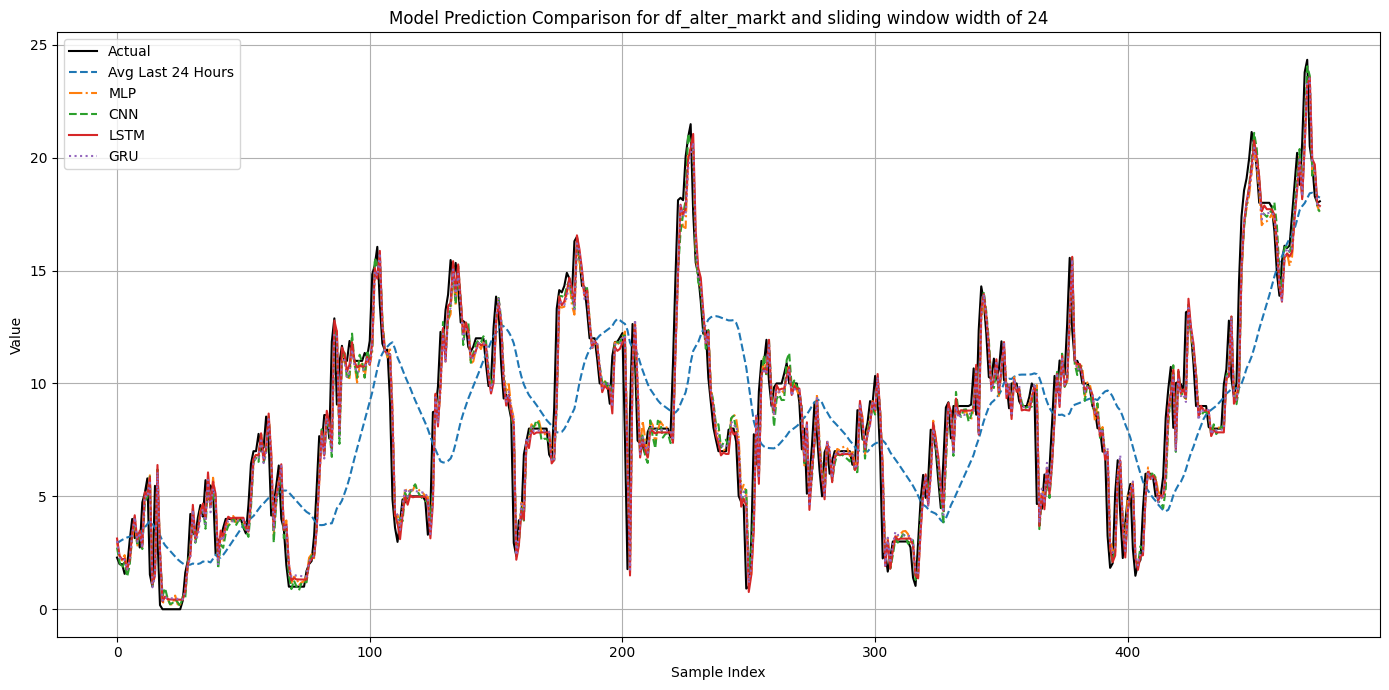

In [531]:
plt.figure(figsize=(14, 7))

plt.plot(predictions_df_alter_markt.index, predictions_df_alter_markt['actual'], label='Actual', color='black')#, marker='o')
plt.plot(predictions_df_alter_markt.index, predictions_df_alter_markt['avg_last_24_hours'], label='Avg Last 24 Hours', linestyle='--')#, marker='x')
# plt.plot(predictions_df_alter_markt.index, predictions_df_alter_markt['last_day'], label='Last Day', linestyle='-')#, marker='s')
# plt.plot(predictions_df_alter_markt.index, predictions_df_alter_markt['no-change'], label='No-Change', linestyle=':')#, marker='*')
plt.plot(predictions_df_alter_markt.index, predictions_df_alter_markt['MLP'], label='MLP', linestyle='-.')#, marker='d')
plt.plot(predictions_df_alter_markt.index, predictions_df_alter_markt['CNN'], label='CNN', linestyle='--')#, marker='^')
plt.plot(predictions_df_alter_markt.index, predictions_df_alter_markt['LSTM'], label='LSTM', linestyle='-')#, marker='v')
plt.plot(predictions_df_alter_markt.index, predictions_df_alter_markt['GRU'], label='GRU', linestyle=':')#, marker='<')

plt.title(f'Model Prediction Comparison for {datasetname} and sliding window width of {sliding_window_width}')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
# plt.xticks(predictions.index)

plt.tight_layout()
plt.show()

### model evaluation df_hauptbahnhof, sliding_window = 48

In [546]:
print(df_hauptbahnhof.shape)
df_hauptbahnhof.head()

(2412, 2)


,index,availableBikeNumber
0,2024-06-17 11:00:00+00:00,0.508475
1,2024-06-17 12:00:00+00:00,5.932203
2,2024-06-17 13:00:00+00:00,11.728814
3,2024-06-17 14:00:00+00:00,15.642857
4,2024-06-17 15:00:00+00:00,30.083333


In [547]:
target = df_hauptbahnhof.loc[:, ["availableBikeNumber"]]
data = df_hauptbahnhof.drop(['index', 'availableBikeNumber'], axis=1)

print('Mean of availableBikeNumber: ', np.sum(target['availableBikeNumber'])/len(target))
full_dataset = target['availableBikeNumber'].values.reshape(-1,1) # reshape because the scaler expects a 2D array

Mean of availableBikeNumber:  13.853250165316519


In [548]:
datasetname = 'df_hauptbahnhof'

sc = MinMaxScaler()
criterion = nn.MSELoss() # loss function: mean-squared error for regression
activation = torch.nn.ReLU()
sliding_window_width = 24 # sliding window width is actually a hyperparameter of the training setup

x_train, y_train, x_val, y_val, x_test, y_test = setup_experiment(
    dataset = full_dataset, 
    seq_len = sliding_window_width, # sliding window width = 48 hours
    test_share = 0.2, 
    val_share = 0.2, 
    scaler = sc)

trainX=torch.Tensor(x_train)
trainY=torch.Tensor(y_train)
valX=torch.Tensor(x_val)
valY=torch.Tensor(y_val)
testX=torch.Tensor(x_test)
testY=torch.Tensor(y_test)

print(datasetname)
print('')
print('Dataset Shape: ', full_dataset.shape)
print('Scaler: ', sc)
print('Loss Function (criterion): ', criterion)
print('Activation Function: ', activation)
print('Sliding Window Width: ', sliding_window_width)
print('-----------------')
print('x_train.shape: ', x_train.shape, ', y_train.shape: ', y_train.shape)
print('x_test.shape: ', x_test.shape, ', y_test.shape: ', y_test.shape)
print('-----------------')
print("Dataset shape: ", full_dataset.shape)
print("Training shape: ", trainX.shape, trainY.shape)
print("Validation shape: ", valX.shape, valY.shape)
print("Testset shape: ", testX.shape, testY.shape)

predictions = pd.DataFrame()         # in this dictionary we will store the actual predictions for each model on the test data
result = pd.DataFrame()  # in this dataframe we will store the results of our methods on the test data

index = pd.MultiIndex.from_product([['avg_last_24_hours'], ['Train', 'Test']], names=['Model', 'Dataset'])
result = pd.DataFrame(columns=['Loss', 'MSE', 'MAE', 'MAPE'], index=index)

print('-----------------')
print('-----------------')
print('Doing Baselines')

testY_pred = baseline_avg_pred_n_steps(x_test, 24)
trainY_pred = baseline_avg_pred_n_steps(x_train, 24)
add_result(result, predictions, None, "avg_last_24_hours", criterion, sc, testY_pred, testY, trainY_pred, trainY, 0)

testY_pred = baseline_last_n_steps(x_test, 24)
trainY_pred = baseline_last_n_steps(x_train, 24)
add_result(result, predictions, None, "last_day", criterion, sc, testY_pred, testY, trainY_pred, trainY, 0)

testY_pred = baseline_zero(x_test, sc)
trainY_pred = baseline_zero(x_train, sc)
add_result(result, predictions, None, "no-change", criterion, sc, testY_pred, testY, trainY_pred, trainY, 0)

print('-----------------')
print('Doing MLP')

# Training parameters
num_epochs = 10000
learning_rate = 0.1

# Model hyperparameters
input_size = sliding_window_width
hidden_size = 6

class Perceptron(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(Perceptron, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 1)

 
    def forward(self, x):  # x shape (dataset, time-steps, features)
        x=x.squeeze(-1)    # x shape (dataset, time-steps)
        
        hidden_layer_output = activation(self.hidden_layer(x))  #relu: x>0 -> x, x<=0 -> 0
        
        return self.output_layer(hidden_layer_output)
    
print('--Traing parameters')
print('num_epochs: ', num_epochs)
print('learning_rate: ', learning_rate)
print('--Model hyperparameters')
print('input_size: ', input_size)
print('hidden_size: ', hidden_size)
print('--Training...')

perceptron_model = Perceptron(input_size, hidden_size)

start_time = time.time()
perceptron_model = train(perceptron_model, num_epochs, learning_rate, criterion, trainX, trainY, valX, valY)
training_time = time.time() - start_time

testY_pred = predict(perceptron_model, testX)
trainY_pred = predict(perceptron_model, trainX)
add_result(result, predictions, perceptron_model, "MLP", criterion, sc, testY_pred, testY, trainY_pred, trainY, training_time)

print('-----------------')
print('Doing CNN')

# Training parameters
num_epochs = 10000
learning_rate = 0.01

# Model hyperparameters
input_size = sliding_window_width
out_channels = 2
kernel_size = 4
stride = 2

class ConvModel(nn.Module):

    def __init__(self, input_size, out_channels, kernel_size, stride):
        super(ConvModel, self).__init__()
        
        self.input_size = input_size # size of features
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride=stride
        
        self.conv1d = nn.Conv1d(1, out_channels, kernel_size, stride=stride)
        
        self.conv1d_output_size=out_channels*math.floor((input_size-kernel_size)/stride +1)
        
        self.hidden_layer_size=int(self.conv1d_output_size/2)
        self.lin = nn.Linear(self.conv1d_output_size, self.hidden_layer_size)  
        self.lin2 = nn.Linear(self.hidden_layer_size, 1)  
        
        
    def forward(self, x):
        x_conv_output = activation(self.conv1d(x))
        x_reshape = x_conv_output.reshape(x_conv_output.size(0), -1)
        x_lin1 = activation(self.lin(x_reshape))
        return self.lin2(x_lin1)
    
print('--Traing parameters')
print('num_epochs: ', num_epochs)
print('learning_rate: ', learning_rate)
print('--Model hyperparameters')
print('input_size: ', input_size)
print('out_channels: ', out_channels)
print('kernel_size: ', kernel_size)
print('stride: ', stride)
print('--Training...')

cnn_model = ConvModel(input_size, out_channels, kernel_size, stride)

start_time = time.time()
cnn_model = train(cnn_model, num_epochs, learning_rate, criterion, trainX.permute(0,2,1), trainY, valX.permute(0,2,1), valY)
training_time = time.time() - start_time

testY_pred = predict(cnn_model, testX.permute(0,2,1))
trainY_pred = predict(cnn_model, trainX.permute(0,2,1))
add_result(result, predictions, cnn_model, "CNN", criterion, sc, testY_pred, testY, trainY_pred, trainY, training_time)

print('-----------------')
print('Doing LSTM')

# Training parameters
num_epochs = 5000
learning_rate = 0.02

# Model hyperparameters
input_size = 1
hidden_size = 2

class LstmModel(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(LstmModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(
            input_size=input_size,       # number of features of each input
            hidden_size=hidden_size,     # size of the hidden state and the cell state
            batch_first=True)            # input and output as (batch, seq, feature)

        self.output_layer = nn.Linear(hidden_size, 1)  
        
        
    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size)  # initialize hidden state before each pass
        
        c_0 = torch.zeros(1, x.size(0), self.hidden_size)  # initialize cell state before each pass
        
        lstm_output, (h_out, c_out) = self.lstm(x, (h_0, c_0))  # lstm_output (batch,time-steps,hidden_size), h_out (layers,batch,hidden_size)
        return self.output_layer(lstm_output[:,-1,:])  # use only output of last time step
    
print('--Traing parameters')
print('num_epochs: ', num_epochs)
print('learning_rate: ', learning_rate)
print('--Model hyperparameters')
print('input_size: ', input_size)
print('hidden_size: ', hidden_size)
print('--Training...')

lstm_model = LstmModel(input_size, hidden_size)

start_time = time.time()
lstm_model = train(lstm_model, num_epochs, learning_rate, criterion, trainX, trainY, valX, valY)
training_time = time.time() - start_time

testY_pred = predict(lstm_model, testX)
trainY_pred = predict(lstm_model, trainX)
add_result(result, predictions, lstm_model, "LSTM", criterion, sc, testY_pred, testY, trainY_pred, trainY, training_time)

print('-----------------')
print('Doing GRU')

# Training parameters
num_epochs = 5000
learning_rate = 0.02

# Model hyperparameters
input_size = 1
hidden_size = 2

class GruModel(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(GruModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.gru = nn.GRU(
            input_size=input_size,       # number of features of each input
            hidden_size=hidden_size,     # size of the hidden state and the cell state
            batch_first=True)            # input and output as (batch, seq, feature)

        self.output_layer = nn.Linear(hidden_size, 1)  
        
        
    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size)  # initialize hidden state before each pass
                
        gru_out, h_out = self.gru(x, h_0)  # lstm_output (batch,time-steps,hidden_size), h_out (layers,batch,hidden_size)
        return self.output_layer(gru_out[:,-1,:])  # use only output of last time step
    
print('--Traing parameters')
print('num_epochs: ', num_epochs)
print('learning_rate: ', learning_rate)
print('--Model hyperparameters')
print('input_size: ', input_size)
print('hidden_size: ', hidden_size)
print('--Training...')

gru_model = GruModel(input_size, hidden_size)

start_time = time.time()
gru_model = train(gru_model, num_epochs, learning_rate, criterion, trainX, trainY, valX, valY)
training_time = time.time() - start_time

testY_pred = predict(gru_model, testX)
trainY_pred = predict(gru_model, trainX)
add_result(result, predictions, gru_model, "GRU", criterion, sc, testY_pred, testY, trainY_pred, trainY, training_time)



predictions_df_hauptbahnhof = predictions.copy()
result_df_hauptbahnhof = result.copy()

df_hauptbahnhof

Dataset Shape:  (2412, 1)
Scaler:  MinMaxScaler()
Loss Function (criterion):  MSELoss()
Activation Function:  ReLU()
Sliding Window Width:  48
-----------------
x_train.shape:  (1419, 48, 1) , y_train.shape:  (1419, 1)
x_test.shape:  (472, 48, 1) , y_test.shape:  (472, 1)
-----------------
Dataset shape:  (2412, 1)
Training shape:  torch.Size([1419, 48, 1]) torch.Size([1419, 1])
Validation shape:  torch.Size([472, 48, 1]) torch.Size([472, 1])
Testset shape:  torch.Size([472, 48, 1]) torch.Size([472, 1])
-----------------
-----------------
Doing Baselines
--Training time:  0 seconds
Added results for avg_last_24_hours to dataframe.
--Training time:  0 seconds
Added results for last_day to dataframe.
--Training time:  0 seconds
Added results for no-change to dataframe.
-----------------
Doing MLP
--Traing parameters
num_epochs:  10000
learning_rate:  0.1
--Model hyperparameters
input_size:  48
hidden_size:  6
--Training...
Epoch: 999, loss: 0.00222, val_loss: 0.00273
Epo

In [549]:
result_df_hauptbahnhof.xs('Train', level='Dataset').sort_values(by='Loss').head(20)

,Loss,MSE,MAE,MAPE,Avg. monthly available bike number deviation,Parameters,Training_Time_in_sec
Model,,,,,,,
MLP,0.002277,0.002277,0.03368,340954421657600.0,2.1,301.0,6.0
CNN,0.002302,0.002302,0.034093,334609357209600.0,2.2,1115.0,21.0
GRU,0.002377,0.002377,0.034963,482058856038400.0,2.2,33.0,177.0
LSTM,0.002479,0.002479,0.035569,475566283161600.0,2.3,43.0,92.0
avg_last_24_hours,0.024767,0.024767,0.11662,2049076887552000.0,7.4,0.0,0.0
last_day,0.041799,0.041799,0.142772,1725238136012800.0,9.1,0.0,0.0
no-change,0.076952,0.076952,0.19439,94.291753,12.3,0.0,0.0


In [550]:
result_df_hauptbahnhof.xs('Test', level='Dataset').sort_values(by='Loss').head(20)

,Loss,MSE,MAE,MAPE,Avg. monthly available bike number deviation,Parameters,Training_Time_in_sec
Model,,,,,,,
CNN,0.002556,0.002556,0.035596,59961468518400.0,2.3,1115.0,NaN
MLP,0.002632,0.002632,0.03636,86497263616000.0,2.3,301.0,NaN
LSTM,0.002671,0.002671,0.036528,171378239078400.0,2.3,43.0,NaN
GRU,0.002722,0.002722,0.036695,155905123942400.0,2.3,33.0,NaN
avg_last_24_hours,0.028108,0.028108,0.134572,1569203106611200.0,8.5,0.0,NaN
last_day,0.046027,0.046027,0.169229,1649704697856000.0,10.7,0.0,NaN
no-change,0.124123,0.124123,0.294231,97.457629,18.7,0.0,NaN


plot predictions

In [551]:
predictions_df_hauptbahnhof.head()

,actual,avg_last_24_hours,last_day,no-change,MLP,CNN,LSTM,GRU
0,19.183334,22.299305,1.350000,0.0,18.491049,18.376862,17.500045,17.859359
1,20.033332,23.042362,4.316667,0.0,17.594504,18.112806,17.612422,16.439276
2,21.133333,23.697223,2.166667,0.0,20.147080,20.005064,19.230403,19.203959
3,19.700001,24.487500,1.866667,0.0,20.662599,21.288950,20.663949,21.080052
4,18.600000,25.230555,1.500000,0.0,19.273227,19.367164,18.348819,18.215031


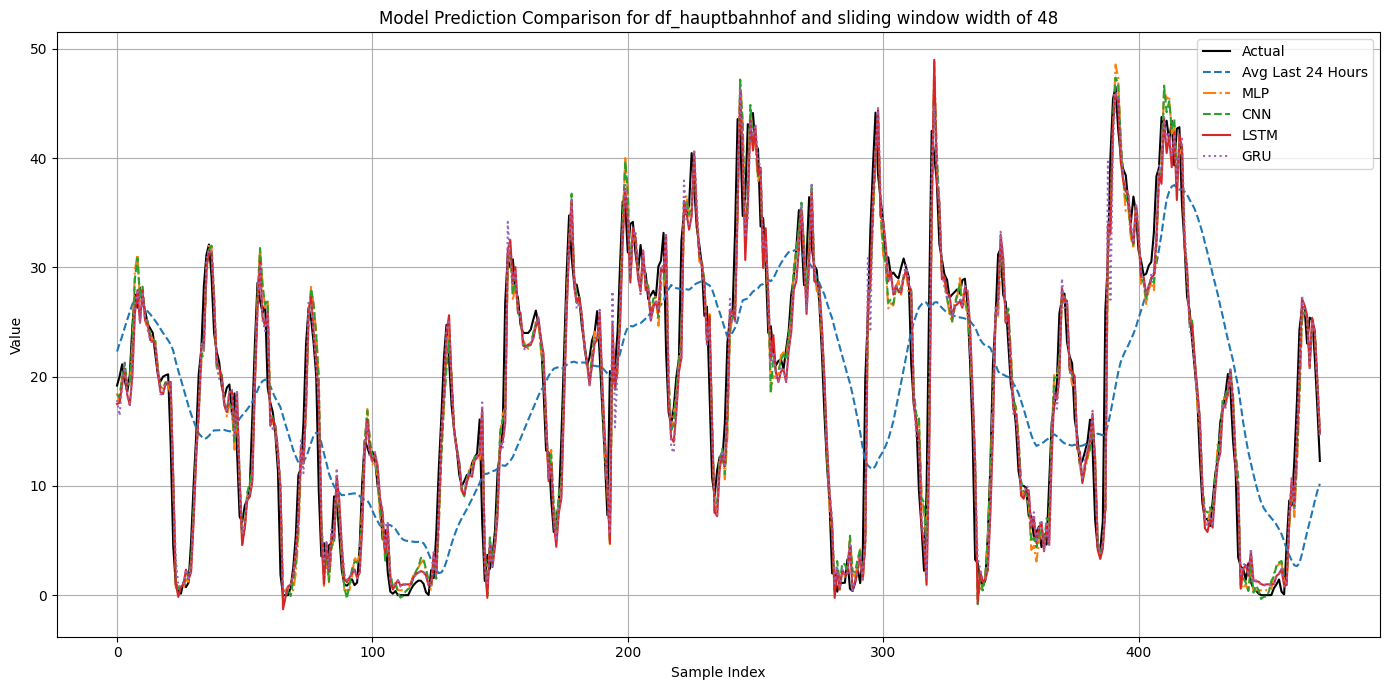

In [552]:
plt.figure(figsize=(14, 7))

plt.plot(predictions_df_hauptbahnhof.index, predictions_df_hauptbahnhof['actual'], label='Actual', color='black')#, marker='o')
plt.plot(predictions_df_hauptbahnhof.index, predictions_df_hauptbahnhof['avg_last_24_hours'], label='Avg Last 24 Hours', linestyle='--')#, marker='x')
# plt.plot(predictions_df_hauptbahnhof.index, predictions_df_hauptbahnhof['last_day'], label='Last Day', linestyle='-')#, marker='s')
# plt.plot(predictions_df_hauptbahnhof.index, predictions_df_hauptbahnhof['no-change'], label='No-Change', linestyle=':')#, marker='*')
plt.plot(predictions_df_hauptbahnhof.index, predictions_df_hauptbahnhof['MLP'], label='MLP', linestyle='-.')#, marker='d')
plt.plot(predictions_df_hauptbahnhof.index, predictions_df_hauptbahnhof['CNN'], label='CNN', linestyle='--')#, marker='^')
plt.plot(predictions_df_hauptbahnhof.index, predictions_df_hauptbahnhof['LSTM'], label='LSTM', linestyle='-')#, marker='v')
plt.plot(predictions_df_hauptbahnhof.index, predictions_df_hauptbahnhof['GRU'], label='GRU', linestyle=':')#, marker='<')

plt.title(f'Model Prediction Comparison for {datasetname} and sliding window width of {sliding_window_width}')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
# plt.xticks(predictions.index)

plt.tight_layout()
plt.show()

### model evaluation df_anleger_dietrichsdorf, sliding_window = 48

In [539]:
print(df_anleger_dietrichsdorf.shape)
df_anleger_dietrichsdorf.head()

(2411, 2)


,index,availableBikeNumber
0,2024-06-17 11:00:00+00:00,5.032787
1,2024-06-17 12:00:00+00:00,6.762712
2,2024-06-17 13:00:00+00:00,6.864407
3,2024-06-17 14:00:00+00:00,5.846154
4,2024-06-17 15:00:00+00:00,5.305556


In [540]:
target = df_anleger_dietrichsdorf.loc[:, ["availableBikeNumber"]]
data = df_anleger_dietrichsdorf.drop(['index', 'availableBikeNumber'], axis=1)

print('Mean of availableBikeNumber: ', np.sum(target['availableBikeNumber'])/len(target))
full_dataset = target['availableBikeNumber'].values.reshape(-1,1) # reshape because the scaler expects a 2D array

Mean of availableBikeNumber:  10.352077308963286


In [541]:
datasetname = 'df_anleger_dietrichsdorf'

sc = MinMaxScaler()
criterion = nn.MSELoss() # loss function: mean-squared error for regression
activation = torch.nn.ReLU()
sliding_window_width = 24 # sliding window width is actually a hyperparameter of the training setup

x_train, y_train, x_val, y_val, x_test, y_test = setup_experiment(
    dataset = full_dataset, 
    seq_len = sliding_window_width, # sliding window width = 48 hours
    test_share = 0.2, 
    val_share = 0.2, 
    scaler = sc)

trainX=torch.Tensor(x_train)
trainY=torch.Tensor(y_train)
valX=torch.Tensor(x_val)
valY=torch.Tensor(y_val)
testX=torch.Tensor(x_test)
testY=torch.Tensor(y_test)

print(datasetname)
print('')
print('Dataset Shape: ', full_dataset.shape)
print('Scaler: ', sc)
print('Loss Function (criterion): ', criterion)
print('Activation Function: ', activation)
print('Sliding Window Width: ', sliding_window_width)
print('-----------------')
print('x_train.shape: ', x_train.shape, ', y_train.shape: ', y_train.shape)
print('x_test.shape: ', x_test.shape, ', y_test.shape: ', y_test.shape)
print('-----------------')
print("Dataset shape: ", full_dataset.shape)
print("Training shape: ", trainX.shape, trainY.shape)
print("Validation shape: ", valX.shape, valY.shape)
print("Testset shape: ", testX.shape, testY.shape)

predictions = pd.DataFrame()         # in this dictionary we will store the actual predictions for each model on the test data
result = pd.DataFrame()  # in this dataframe we will store the results of our methods on the test data

index = pd.MultiIndex.from_product([['avg_last_24_hours'], ['Train', 'Test']], names=['Model', 'Dataset'])
result = pd.DataFrame(columns=['Loss', 'MSE', 'MAE', 'MAPE'], index=index)

print('-----------------')
print('-----------------')
print('Doing Baselines')

testY_pred = baseline_avg_pred_n_steps(x_test, 24)
trainY_pred = baseline_avg_pred_n_steps(x_train, 24)
add_result(result, predictions, None, "avg_last_24_hours", criterion, sc, testY_pred, testY, trainY_pred, trainY, 0)

testY_pred = baseline_last_n_steps(x_test, 24)
trainY_pred = baseline_last_n_steps(x_train, 24)
add_result(result, predictions, None, "last_day", criterion, sc, testY_pred, testY, trainY_pred, trainY, 0)

testY_pred = baseline_zero(x_test, sc)
trainY_pred = baseline_zero(x_train, sc)
add_result(result, predictions, None, "no-change", criterion, sc, testY_pred, testY, trainY_pred, trainY, 0)

print('-----------------')
print('Doing MLP')

# Training parameters
num_epochs = 10000
learning_rate = 0.1

# Model hyperparameters
input_size = sliding_window_width
hidden_size = 6

class Perceptron(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(Perceptron, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 1)

 
    def forward(self, x):  # x shape (dataset, time-steps, features)
        x=x.squeeze(-1)    # x shape (dataset, time-steps)
        
        hidden_layer_output = activation(self.hidden_layer(x))  #relu: x>0 -> x, x<=0 -> 0
        
        return self.output_layer(hidden_layer_output)
    
print('--Traing parameters')
print('num_epochs: ', num_epochs)
print('learning_rate: ', learning_rate)
print('--Model hyperparameters')
print('input_size: ', input_size)
print('hidden_size: ', hidden_size)
print('--Training...')

perceptron_model = Perceptron(input_size, hidden_size)

start_time = time.time()
perceptron_model = train(perceptron_model, num_epochs, learning_rate, criterion, trainX, trainY, valX, valY)
training_time = time.time() - start_time

testY_pred = predict(perceptron_model, testX)
trainY_pred = predict(perceptron_model, trainX)
add_result(result, predictions, perceptron_model, "MLP", criterion, sc, testY_pred, testY, trainY_pred, trainY, training_time)

print('-----------------')
print('Doing CNN')

# Training parameters
num_epochs = 10000
learning_rate = 0.01

# Model hyperparameters
input_size = sliding_window_width
out_channels = 2
kernel_size = 4
stride = 2

class ConvModel(nn.Module):

    def __init__(self, input_size, out_channels, kernel_size, stride):
        super(ConvModel, self).__init__()
        
        self.input_size = input_size # size of features
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride=stride
        
        self.conv1d = nn.Conv1d(1, out_channels, kernel_size, stride=stride)
        
        self.conv1d_output_size=out_channels*math.floor((input_size-kernel_size)/stride +1)
        
        self.hidden_layer_size=int(self.conv1d_output_size/2)
        self.lin = nn.Linear(self.conv1d_output_size, self.hidden_layer_size)  
        self.lin2 = nn.Linear(self.hidden_layer_size, 1)  
        
        
    def forward(self, x):
        x_conv_output = activation(self.conv1d(x))
        x_reshape = x_conv_output.reshape(x_conv_output.size(0), -1)
        x_lin1 = activation(self.lin(x_reshape))
        return self.lin2(x_lin1)
    
print('--Traing parameters')
print('num_epochs: ', num_epochs)
print('learning_rate: ', learning_rate)
print('--Model hyperparameters')
print('input_size: ', input_size)
print('out_channels: ', out_channels)
print('kernel_size: ', kernel_size)
print('stride: ', stride)
print('--Training...')

cnn_model = ConvModel(input_size, out_channels, kernel_size, stride)

start_time = time.time()
cnn_model = train(cnn_model, num_epochs, learning_rate, criterion, trainX.permute(0,2,1), trainY, valX.permute(0,2,1), valY)
training_time = time.time() - start_time

testY_pred = predict(cnn_model, testX.permute(0,2,1))
trainY_pred = predict(cnn_model, trainX.permute(0,2,1))
add_result(result, predictions, cnn_model, "CNN", criterion, sc, testY_pred, testY, trainY_pred, trainY, training_time)

print('-----------------')
print('Doing LSTM')

# Training parameters
num_epochs = 5000
learning_rate = 0.02

# Model hyperparameters
input_size = 1
hidden_size = 2

class LstmModel(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(LstmModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(
            input_size=input_size,       # number of features of each input
            hidden_size=hidden_size,     # size of the hidden state and the cell state
            batch_first=True)            # input and output as (batch, seq, feature)

        self.output_layer = nn.Linear(hidden_size, 1)  
        
        
    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size)  # initialize hidden state before each pass
        
        c_0 = torch.zeros(1, x.size(0), self.hidden_size)  # initialize cell state before each pass
        
        lstm_output, (h_out, c_out) = self.lstm(x, (h_0, c_0))  # lstm_output (batch,time-steps,hidden_size), h_out (layers,batch,hidden_size)
        return self.output_layer(lstm_output[:,-1,:])  # use only output of last time step
    
print('--Traing parameters')
print('num_epochs: ', num_epochs)
print('learning_rate: ', learning_rate)
print('--Model hyperparameters')
print('input_size: ', input_size)
print('hidden_size: ', hidden_size)
print('--Training...')

lstm_model = LstmModel(input_size, hidden_size)

start_time = time.time()
lstm_model = train(lstm_model, num_epochs, learning_rate, criterion, trainX, trainY, valX, valY)
training_time = time.time() - start_time

testY_pred = predict(lstm_model, testX)
trainY_pred = predict(lstm_model, trainX)
add_result(result, predictions, lstm_model, "LSTM", criterion, sc, testY_pred, testY, trainY_pred, trainY, training_time)

print('-----------------')
print('Doing GRU')

# Training parameters
num_epochs = 5000
learning_rate = 0.02

# Model hyperparameters
input_size = 1
hidden_size = 2

class GruModel(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(GruModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.gru = nn.GRU(
            input_size=input_size,       # number of features of each input
            hidden_size=hidden_size,     # size of the hidden state and the cell state
            batch_first=True)            # input and output as (batch, seq, feature)

        self.output_layer = nn.Linear(hidden_size, 1)  
        
        
    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size)  # initialize hidden state before each pass
                
        gru_out, h_out = self.gru(x, h_0)  # lstm_output (batch,time-steps,hidden_size), h_out (layers,batch,hidden_size)
        return self.output_layer(gru_out[:,-1,:])  # use only output of last time step
    
print('--Traing parameters')
print('num_epochs: ', num_epochs)
print('learning_rate: ', learning_rate)
print('--Model hyperparameters')
print('input_size: ', input_size)
print('hidden_size: ', hidden_size)
print('--Training...')

gru_model = GruModel(input_size, hidden_size)

start_time = time.time()
gru_model = train(gru_model, num_epochs, learning_rate, criterion, trainX, trainY, valX, valY)
training_time = time.time() - start_time

testY_pred = predict(gru_model, testX)
trainY_pred = predict(gru_model, trainX)
add_result(result, predictions, gru_model, "GRU", criterion, sc, testY_pred, testY, trainY_pred, trainY, training_time)



predictions_df_anleger_dietrichsdorf = predictions.copy()
result_df_anleger_dietrichsdorf = result.copy()

df_anleger_dietrichsdorf

Dataset Shape:  (2411, 1)
Scaler:  MinMaxScaler()
Loss Function (criterion):  MSELoss()
Activation Function:  ReLU()
Sliding Window Width:  24
-----------------
x_train.shape:  (1432, 24, 1) , y_train.shape:  (1432, 1)
x_test.shape:  (477, 24, 1) , y_test.shape:  (477, 1)
-----------------
Dataset shape:  (2411, 1)
Training shape:  torch.Size([1432, 24, 1]) torch.Size([1432, 1])
Validation shape:  torch.Size([477, 24, 1]) torch.Size([477, 1])
Testset shape:  torch.Size([477, 24, 1]) torch.Size([477, 1])
-----------------
-----------------
Doing Baselines
--Training time:  0 seconds
Added results for avg_last_24_hours to dataframe.
--Training time:  0 seconds
Added results for last_day to dataframe.
--Training time:  0 seconds
Added results for no-change to dataframe.
-----------------
Doing MLP
--Traing parameters
num_epochs:  10000
learning_rate:  0.1
--Model hyperparameters
input_size:  24
hidden_size:  6
--Training...
Epoch: 999, loss: 0.00114, val_loss: 0.

In [542]:
result_df_anleger_dietrichsdorf.xs('Train', level='Dataset').sort_values(by='Loss').head(20)

,Loss,MSE,MAE,MAPE,Avg. monthly available bike number deviation,Parameters,Training_Time_in_sec
Model,,,,,,,
MLP,0.000996,0.000996,0.018829,190168603033600.0,0.6,157.0,6.0
GRU,0.001017,0.001017,0.018321,151943118848000.0,0.5,33.0,81.0
CNN,0.001018,0.001018,0.018693,162589363404800.0,0.6,275.0,17.0
LSTM,0.00102,0.00102,0.018326,157641382297600.0,0.5,43.0,51.0
avg_last_24_hours,0.008977,0.008977,0.070572,745540943872000.0,2.1,0.0,0.0
last_day,0.0217,0.0217,0.110125,1090959861350400.0,3.3,0.0,0.0
no-change,0.144665,0.144665,0.325653,98.533517,9.8,0.0,0.0


In [543]:
result_df_anleger_dietrichsdorf.xs('Test', level='Dataset').sort_values(by='Loss').head(20)

,Loss,MSE,MAE,MAPE,Avg. monthly available bike number deviation,Parameters,Training_Time_in_sec
Model,,,,,,,
CNN,0.000895,0.000895,0.017596,66294552985600.0,0.5,275.0,NaN
LSTM,0.000895,0.000895,0.017025,87876652236800.0,0.5,43.0,NaN
GRU,0.000906,0.000906,0.017037,85649863475200.0,0.5,33.0,NaN
MLP,0.000914,0.000914,0.017986,125410934784000.0,0.5,157.0,NaN
avg_last_24_hours,0.006108,0.006108,0.059777,751497065267200.0,1.8,0.0,NaN
last_day,0.0198,0.0198,0.09591,827047647641600.0,2.9,0.0,NaN
no-change,0.072164,0.072164,0.23509,98.532492,7.1,0.0,NaN


plot predictions

In [544]:
predictions_df_anleger_dietrichsdorf.head()

,actual,avg_last_24_hours,last_day,no-change,MLP,CNN,LSTM,GRU
0,5.0,11.341666,26.000000,0.0,4.453350,5.282894,5.039947,5.030894
1,5.0,10.466666,26.000000,0.0,5.322317,5.350797,5.039404,5.030741
2,5.0,9.591667,26.000000,0.0,5.566973,5.431415,5.039579,5.030759
3,5.0,8.716667,25.883333,0.0,5.602165,5.491056,5.039528,5.030753
4,5.0,7.846528,26.783334,0.0,4.869886,5.244753,5.039545,5.030755


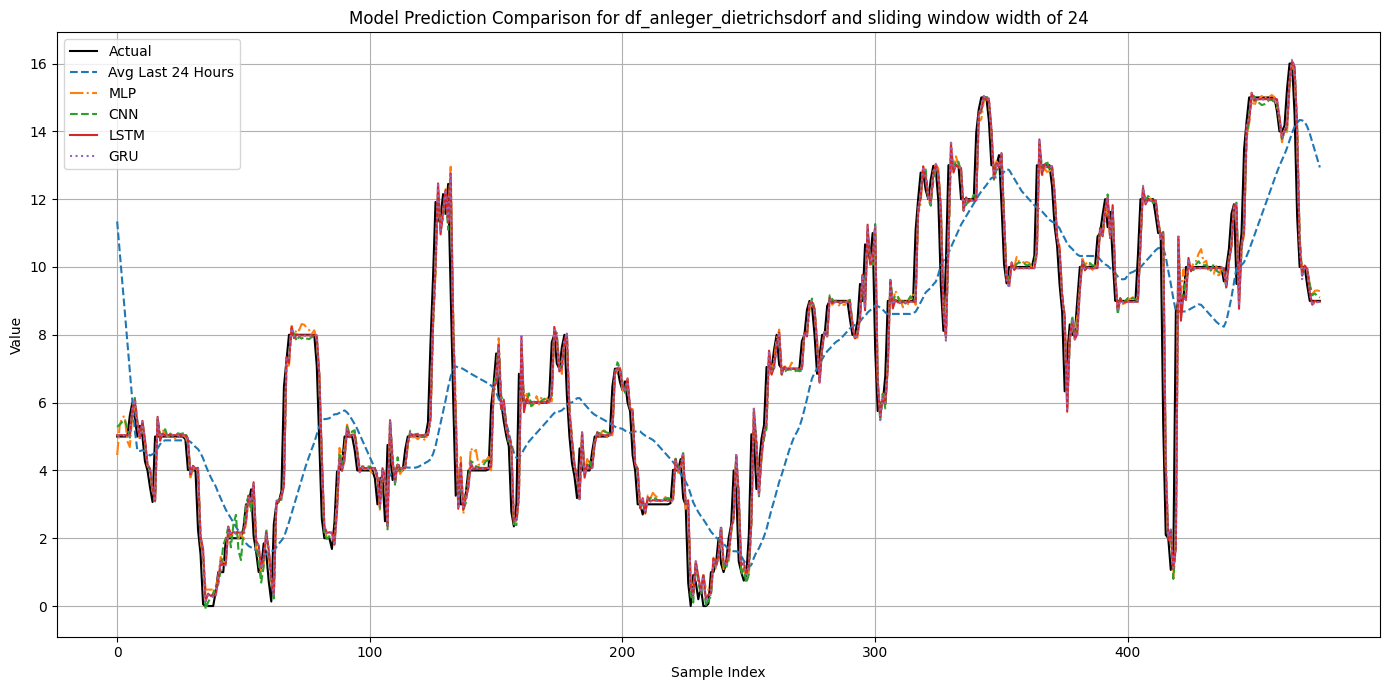

In [545]:
plt.figure(figsize=(14, 7))

plt.plot(predictions_df_anleger_dietrichsdorf.index, predictions_df_anleger_dietrichsdorf['actual'], label='Actual', color='black')#, marker='o')
plt.plot(predictions_df_anleger_dietrichsdorf.index, predictions_df_anleger_dietrichsdorf['avg_last_24_hours'], label='Avg Last 24 Hours', linestyle='--')#, marker='x')
# plt.plot(predictions_df_anleger_dietrichsdorf.index, predictions_df_anleger_dietrichsdorf['last_day'], label='Last Day', linestyle='-')#, marker='s')
# plt.plot(predictions_df_anleger_dietrichsdorf.index, predictions_df_alter_markt['no-change'], label='No-Change', linestyle=':')#, marker='*')
plt.plot(predictions_df_anleger_dietrichsdorf.index, predictions_df_anleger_dietrichsdorf['MLP'], label='MLP', linestyle='-.')#, marker='d')
plt.plot(predictions_df_anleger_dietrichsdorf.index, predictions_df_anleger_dietrichsdorf['CNN'], label='CNN', linestyle='--')#, marker='^')
plt.plot(predictions_df_anleger_dietrichsdorf.index, predictions_df_anleger_dietrichsdorf['LSTM'], label='LSTM', linestyle='-')#, marker='v')
plt.plot(predictions_df_anleger_dietrichsdorf.index, predictions_df_anleger_dietrichsdorf['GRU'], label='GRU', linestyle=':')#, marker='<')

plt.title(f'Model Prediction Comparison for {datasetname} and sliding window width of {sliding_window_width}')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
# plt.xticks(predictions.index)

plt.tight_layout()
plt.show()

***
# geo data test

c:\Users\JustusHeilingbrunner\Documents\UNI\WS_2024_25\Application_Project_2024\.venv\Lib\site-packages\osmnx\features.py:300: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union


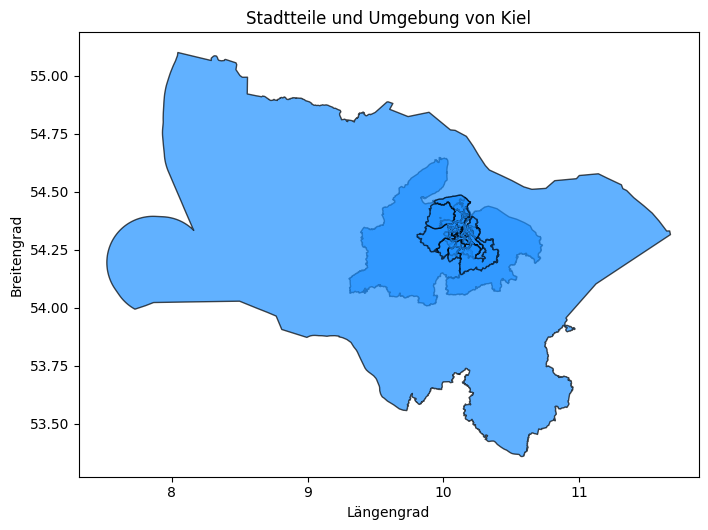

In [ ]:
# Definiere den Ort zur Abfrage ("place")
place_name = "Kiel, Germany"

# Bestimme die tags zum Abrufen von administrativen Grenzen (z.B. Stadtteile)
tags = {'boundary': 'administrative', 'admin_level': ['6','10']}

# Lade die Features basierend auf diesen Tags in dem Gebiet um Kiel
# Ein häufig verwendeter Trick ist, ganz Schleswig-Holstein zu nehmen und es später zu filtern:
boundary_gdf = ox.geocode_to_gdf(place_name)
kiel_and_surroundings = ox.features_from_place(place_name, tags=tags)

# Plotten, um die Sichtbarkeit der Zonierung zu zeigen
fig, ax = plt.subplots(figsize=(8, 8))
boundary_gdf.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=2)
kiel_and_surroundings.plot(ax=ax, color='dodgerblue', edgecolor='black', linewidth=1, alpha=0.7)

# Anpassen und Anzeigen des Plots
plt.title('Stadtteile und Umgebung von Kiel')
plt.xlabel('Längengrad')
plt.ylabel('Breitengrad')
plt.show()

In [ ]:
tags = {'building': True}
geo_test = ox.features_from_point(
    center_point=(54.322469, 10.132222),
    tags=tags,
    dist=1000)
geo_test = geo_test.reset_index()
# geo_test = geo_test[geo_test.element_type=='relation']
# geo_test = geo_test[['name','geometry']]

In [ ]:
geo_test.head(2)

,element_type,osmid,geometry,opening_hours,access,level,wheelchair,material,amenity,operator,...,bar,frequency,shelter_type,playground,construction,ways,police,type,name:etymology:wikidata,loc_name
0,node,8860572219,POINT (10.12421 54.32084),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,8860572222,POINT (10.12405 54.32099),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
